In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 
import numpy
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print(len(train_set))

105829


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


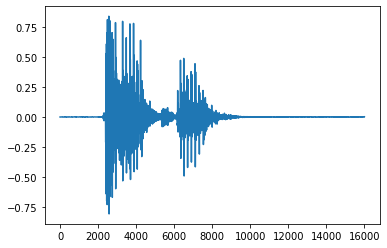

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
len(labels)

35

In [7]:
len(labels)

35

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [13]:
'''
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

'''
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=1, n_channel=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(7,7),stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d((2,4))
        self.conv2 = nn.Conv2d(n_channel, 2*n_channel, kernel_size=(5,5),stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(2*n_channel)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(2*n_channel, 4 * n_channel, kernel_size=(3,3),stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(4 * n_channel)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, n_output)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=35, bias=True)
)
Number of parameters: 26323


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [15]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [16]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [17]:
transform_spec = torchaudio.transforms.Spectrogram()
transform = torchaudio.transforms.MFCC().to(device)

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [18]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    transformed_spec = transform_spec(waveform)
    tran_sum = torch.sum(transformed_spec[0,:,:],dim=0)
   
    max_value = torch.max(tran_sum)
    
    for t in range(len(tran_sum)):
        if(tran_sum[t]> (max_value/10)):
            start=t*200
            break    
    print(start)
    
    if label == 'left':
        attack_train.append((waveform, start, sample_rate, label, speaker_id, utterance_number))
        
    else:
        maintain_train.append((waveform,start, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))

        

0
2400
5200
2200
3400
6800
6800
1800
2800
7200
3200
4200
8200
4600
4000
4000
5000
5200
7000
7200
7000
4000
2000
1400
4800
3000
3200
7200
7000
6400
5400
6000
4000
5800
4600
4400
7000
3600
3200
3400
2400
6600
2200
3400
4600
2400
1800
7600
7600
8000
2600
2000
800
5800
5600
4000
3400
4800
10800
2400
1400
800
1400
7600
6000
5600
5600
6200
8400
11200
10200
8800
7200
4200
2200
4200
2200
3200
3600
3600
3400
4400
10800
5800
4000
4200
3800
4800
5000
6200
7000
6600
6600
8000
7400
6200
8400
12200
800
8800
2200
2400
6200
4000
6200
7600
5200
1600
1000
0
0
0
10600
7000
4800
5200
7000
8800
9000
10800
10200
6200
12600
7600
6400
7400
9400
9000
6800
6400
6000
4600
4800
6200
6600
10000
6400
5000
6200
12200
5200
3400
2800
3600
5400
4000
3400
3400
4800
0
5000
3400
7200
15000
11200
10000
8200
5800
10600
8400
6400
8600
5800
7200
6800
10800
7600
7200
3600
9600
6600
6000
4800
9400
11200
400
0
4600
9400
6600
6400
2800
4600
3400
6600
1800
5000
3200
2000
2200
3600
5200
9400
6200
4000
11400
5000
7200
7800
11000
740

2000
5200
400
800
2600
1800
9600
11400
8800
1000
5000
4200
4800
7200
6400
8400
9400
2400
5600
9400
6200
5400
8800
10800
9200
6400
9600
2200
7000
10000
9200
7600
5400
1200
2800
7600
0
400
7200
3000
8200
8000
7600
7800
2400
7000
6400
3200
3000
0
0
5800
8000
8200
8400
1000
8200
8800
4200
6200
400
10200
9600
2400
5800
4800
10600
9200
8200
5000
4000
9200
5000
5600
9800
6000
2400
3600
1000
6800
200
9600
7800
6600
8400
10400
7800
10600
7200
0
0
6600
4400
7200
5400
6200
5400
8800
9600
4600
6800
9400
9200
6400
12400
4200
8000
2400
4400
1600
7400
8200
7400
3200
9600
10400
200
8800
7600
7800
9600
5800
6000
5000
5000
3400
6200
600
2800
1400
10600
8200
9800
3600
10600
7600
7200
10400
8600
5200
8200
5200
9400
4200
3600
4200
6800
1800
3000
3800
8000
6400
5800
0
0
8200
4400
3800
8600
7000
3200
2600
3800
5400
4600
9200
5600
6200
8200
9000
7800
5400
600
5600
3000
3800
10600
14200
7800
8000
6800
7400
7800
8000
2000
8800
1400
5000
12800
7800
8400
6400
9400
10600
2000
4400
4400
800
400
8200
3600
6600
11200

7600
6600
3800
9600
9000
1600
7200
7400
7200
6400
1000
6600
8800
3800
4200
800
7600
8200
6000
6400
10600
1200
5000
5000
8000
8800
9000
4400
6800
6200
0
10000
6800
3000
0
7200
4000
8400
4000
7400
5800
5600
9600
8800
5800
8600
3000
3600
2600
5800
10000
5800
6000
6400
5800
6800
14200
6800
10400
8600
9400
9200
8800
2200
1200
8800
800
9400
6200
10200
7000
6200
3000
4400
11400
2000
0
10800
9800
9000
9000
3600
8400
12200
4800
7600
5600
6200
7000
6200
10400
8600
3600
4400
4000
8400
5000
7200
3600
7600
9600
1800
1600
6200
9400
4800
8400
8200
6200
9000
7600
8200
6800
7000
8800
4400
5800
4200
8000
6000
8200
2800
5600
7800
5200
2200
6800
8800
10800
2800
400
8600
10400
8600
2400
8400
7600
12000
6400
6800
7400
3200
10600
7400
5600
11000
0
10000
9400
8000
8400
7400
4600
7600
8600
4400
3400
3400
9800
8400
9200
4200
400
3600
4800
6800
6200
7800
8200
7800
2800
5800
4000
9600
6600
6800
6600
9000
0
4000
1000
4800
7000
6200
6200
5400
5200
4000
0
9800
8200
9600
6800
8800
7400
400
4600
5400
3600
9600
7000
74

11800
5000
800
1200
6200
6000
6000
11000
10200
10600
3800
2400
1600
2600
0
7600
600
2200
5400
15800
7200
9400
5400
7800
9800
12800
3000
800
8800
4800
600
6400
3000
5400
2800
4600
0
1400
4000
2600
10800
10400
800
1400
1600
10600
5000
5000
8800
6600
5400
11400
9200
400
8600
6800
9200
8800
7600
9600
8400
8400
6400
7800
2800
0
8000
5600
6800
3000
8600
5400
4200
4200
4200
4200
4200
4200
4200
6600
5400
1400
8000
11400
9000
8600
1800
8000
7400
8800
6200
5000
3600
5000
0
6400
7400
0
1600
5000
9000
5800
6800
200
0
9200
6200
5000
6400
8600
5400
5800
4200
15000
2200
4600
5200
6800
5800
6000
3200
4200
4000
9800
4400
8400
6600
3400
5200
6800
7000
7600
4600
1600
8600
7400
3800
400
6600
5000
5200
4400
4600
3000
4400
4400
2200
4200
3200
8600
8800
4200
7200
8000
2200
2200
2200
6600
5800
9200
3000
3200
8800
3000
7000
8000
5600
3600
2000
4200
3600
6600
5000
3200
5400
8600
7600
8800
8600
9000
2600
5800
7800
9600
8400
4400
4200
10400
7600
1200
7000
6800
13400
8200
7400
9200
8600
9600
6800
7200
9600
11000
2

4000
8600
6400
1200
4800
8200
6800
5800
6200
600
5800
2600
6200
6400
9800
4600
1200
2400
400
3000
4000
2800
6200
8000
6200
9000
200
9600
8800
5600
5200
7200
7000
8200
12400
5800
5000
0
3800
6200
6600
0
0
5200
13600
11800
3200
2600
4600
2200
1400
9400
8000
2200
8200
7600
10000
6400
12800
3200
0
0
8400
7200
9000
4000
4000
7200
9400
12800
6000
14000
14000
7000
7200
13200
6200
5600
7600
3400
6000
7400
12200
8800
8000
9200
7800
4600
6200
3000
9400
6200
5400
7000
10600
9800
7000
6800
1600
4800
6000
10400
8200
9800
5400
7200
9200
9400
2200
7000
6600
4800
8000
7400
7800
7200
6200
8200
1800
3400
7000
8000
6600
9000
10000
8800
200
800
5400
4000
1800
9000
200
2600
3400
6800
6200
8800
7200
9400
400
9800
7800
6600
5000
10400
10400
5000
13400
7000
8400
0
0
8400
8800
8600
5200
6000
10400
0
12400
11400
8000
10400
4600
6600
8400
0
2200
0
10200
2400
2000
0
5400
12400
6000
5400
6800
0
8000
8200
3200
6400
7200
8000
10400
4600
5400
1000
200
4800
7600
10800
9800
0
0
6800
11400
1800
6400
5600
9200
1800
10800

5200
0
7600
2200
6000
10200
3000
3200
4000
4600
400
0
10000
6000
5200
6400
8200
5800
6600
1600
3200
2600
2800
400
8800
3600
10600
1800
4600
7200
1400
3400
8800
2800
10000
3400
8400
5000
2600
5000
2200
6400
400
1600
2000
3400
6800
600
7200
4200
6000
5800
6600
7800
3600
6200
7600
8600
8000
9000
7600
4200
0
1400
7600
4200
7800
7800
4400
6200
6000
1800
7800
3400
3600
0
10000
7800
3000
3000
4000
0
6800
9200
1400
7000
6800
2200
5600
6000
9200
0
0
0
5200
1400
5400
6400
5400
6600
7000
2800
3000
5200
4400
10400
9200
0
6200
5400
1800
8600
2600
3200
4200
4200
0
9400
4000
7600
5400
6200
9400
9800
8200
9000
3000
800
3800
0
8600
0
2800
5800
7800
3200
8600
8800
3600
2800
6800
7800
4000
6200
2200
5200
5000
8200
8000
2400
2200
4800
4800
3400
7600
5600
6200
9000
1000
5600
6600
10200
9800
10800
4400
7400
6000
6800
7400
5600
5800
2200
4600
6200
2400
9600
10000
7400
5800
7000
7600
0
2800
7600
4000
6400
8600
800
7400
1400
8600
600
800
7600
4600
4000
400
2200
6400
1600
400
3000
5400
0
0
12000
7000
6200
0
840

6000
9400
6200
6200
7600
7600
8000
3600
8600
0
8800
4400
6800
2400
4000
1000
600
1600
7200
7000
1600
2000
1800
2200
1600
7000
2800
4400
5400
4600
4800
1800
3200
2800
7800
1400
800
6200
7000
7400
6600
4200
5800
8000
6800
8400
8200
4800
3200
6200
5200
4200
3400
5200
4200
0
2400
0
0
1400
1800
7400
9200
9000
8000
7800
3200
4000
2800
6400
6200
6400
5400
9000
5400
6000
2200
6000
5200
6000
5000
3800
3800
8800
5000
200
1200
7600
6400
6200
5200
600
7600
9400
10400
8000
7000
9800
6600
4200
3400
2400
2600
2200
2000
4800
1800
5400
6800
3000
7200
5800
7800
800
4000
3000
6800
6200
4200
4200
3600
6000
7400
4600
8600
1200
7800
6000
6800
11800
2800
200
3800
4000
2600
8200
800
8000
7600
5000
6800
9000
3800
4400
10200
800
5000
9800
8800
5600
6400
5600
11200
10000
7800
4200
6000
7400
3800
1000
8800
3600
8400
7800
8800
9200
7800
7400
5800
2200
3400
4400
1600
1600
7200
3400
3600
3000
9400
4200
4800
4600
2800
3200
5000
8600
6000
9600
10000
5800
10200
2600
3600
4800
7000
3600
7000
7000
6000
6000
6400
6200
380

2200
1400
1600
2000
600
9000
8000
1800
4800
3400
8200
6000
4400
6000
4200
3000
5800
400
3200
3200
7000
3800
2800
5000
2400
400
8200
200
4800
2600
4400
10800
2800
6800
2400
9200
1600
7400
3000
8000
6800
3800
12400
2200
800
11800
7200
1800
200
11000
400
7800
0
2000
3400
9400
6800
6600
8000
8400
5600
4400
3600
5800
2800
5400
9200
3000
9200
4200
6000
7200
8200
4600
3000
9000
6000
6800
4000
6600
3200
6000
5400
8400
6600
5000
0
0
6400
3000
4200
5400
9000
4800
5200
3200
5000
2200
0
15000
4200
9800
1000
1600
400
1600
5800
5600
3200
8400
7800
6000
0
7600
11000
6000
5800
7000
8200
7600
8200
7600
7800
4400
8600
1600
3600
11600
5600
5800
5800
5800
4600
4400
4600
2600
5200
3800
7000
3200
9800
4800
4200
4400
6600
4800
4800
3800
4600
11800
5400
5000
3600
3000
4200
6200
6400
4600
6800
7800
10000
7000
6600
5800
5200
5400
1600
4800
2200
4800
1000
2400
3200
4800
8000
7200
2600
5000
5000
3800
4400
3000
4200
6800
6400
2200
6800
12200
2800
2400
8600
7600
8400
1400
2400
7000
8000
5200
6200
6200
7800
4800
620

6600
2600
7600
3200
3400
8600
2600
1600
2200
2200
0
0
2400
6400
10400
10200
0
800
8000
0
10600
7400
400
7800
8200
7600
9800
7000
8000
6400
7600
5800
7000
7200
5200
7200
5600
3000
2400
1200
9400
7600
15400
7000
6000
7800
6600
5600
8800
7200
9400
200
7400
4400
6400
8000
7600
0
0
3000
3200
4000
2800
4600
5800
5600
3200
7800
7800
10400
7400
8200
600
3800
7200
1200
7200
3800
3600
4400
2000
3200
3400
11800
7200
10800
200
200
6800
2800
7800
4000
6200
4600
6200
5800
7200
5800
10000
9200
4000
9000
7200
8400
6400
3600
2800
3600
200
0
11400
0
6800
10200
7400
5800
10800
8800
10200
1400
6200
7400
7000
8000
7800
8400
4400
5200
7000
5600
8200
7600
7400
10000
2200
8800
2200
10200
4200
2200
5200
4200
5000
200
9000
8600
9400
5800
0
3600
6400
3400
3000
7000
8400
800
11800
4600
9800
7000
4200
2400
9400
4400
7800
5600
6200
6800
4200
4600
1800
5800
4600
2200
1600
8800
8000
6000
7400
7200
8800
7000
7600
6600
3000
2800
3200
11000
6600
7600
7800
8000
3600
5200
5800
6200
1000
12800
12800
9400
8200
2400
800
400


10600
6400
4800
1400
7400
4400
7000
9600
6400
2600
2800
3800
3400
8800
9400
200
10000
6400
5600
5800
5600
800
7400
5400
7400
9000
5600
600
800
3200
3200
6400
3400
5400
4000
9200
6800
200
5200
2800
2400
9200
4400
2400
2000
2800
4000
13800
9400
8000
5400
8800
9200
9400
400
8200
5600
2200
8000
6800
7400
3200
3000
9400
1400
9800
6400
2400
3600
1000
10800
6800
5000
8800
4600
4000
9400
9600
0
0
400
8400
9200
5200
4000
4000
0
14400
7200
0
8400
5400
7800
11800
12400
7200
8800
5400
2200
5400
11800
4600
5400
6200
11600
8200
9200
11200
9400
7000
6600
4000
600
6800
8000
6600
7600
4600
3800
11200
7000
8600
5400
5200
4000
3800
5000
3200
7400
8800
7200
6800
0
7200
3000
7600
9800
10200
3200
3200
9200
3400
9200
3800
6000
10400
8400
8600
3200
9000
2600
2600
3400
7800
6000
6200
7000
6400
7200
3200
4400
6600
6400
8200
5600
3800
4800
8400
1800
4200
5200
7400
5000
3800
3400
5000
5600
5800
7400
8800
4400
2200
5000
3000
2400
0
400
2400
5600
4200
0
7000
6000
4600
9000
3600
10200
12000
600
2000
9400
400
200
660

9600
4000
5400
6600
9400
6400
4400
6000
12200
8200
5800
4000
2200
6200
6800
7800
7400
11600
6200
6800
9600
9200
6400
8200
1600
8200
0
4200
5400
3000
7200
11200
3600
7800
5800
9000
8600
11000
9200
8000
6000
8600
9800
8800
4400
3600
4800
1400
4800
11400
8400
1800
3200
3400
1000
1000
0
3600
8200
4400
4800
4400
12800
13400
11600
3200
800
3200
3200
4000
7800
3000
5000
6000
4600
9600
4800
5800
4600
9200
10800
8600
8800
5400
0
8400
7800
6600
6000
6000
4400
7400
8800
10000
6800
5600
12000
5000
5600
7600
7400
5600
5000
5400
6000
10600
9200
4800
3400
4000
8000
5600
3000
1800
600
9600
9200
8800
5200
8200
4800
4600
4200
4200
200
7800
1800
5800
9800
10200
7400
5000
7600
0
0
400
4600
6000
8600
5000
10400
8000
3600
3000
6000
6000
6200
3400
4200
6200
5200
5400
4200
4200
4400
5600
7600
10000
14600
8000
5400
8000
3800
1800
8200
8400
5200
6200
4000
3000
3000
3200
1800
8600
8200
8200
6200
6200
5200
2000
4600
5400
3000
8600
7400
7800
10000
1800
4800
3800
8400
8800
800
3400
9600
15400
13800
3600
9200
3400
3

11200
2000
4200
10600
5400
4400
3600
8000
7200
4400
5800
2800
5000
3800
8800
6200
6200
6800
8600
11000
4800
7800
5800
4200
4200
4200
5000
15600
3600
7600
7600
6600
3400
7800
9600
4600
4600
3200
7200
2600
10000
10600
7400
2400
4600
2400
5000
7200
4800
8000
9600
9000
9800
7600
4400
6800
6600
6800
4000
2800
4400
9600
6200
4000
7600
6800
6400
5000
8800
6600
5400
4800
4200
11400
2200
5600
400
12200
400
5200
3800
2400
3400
5200
6000
10800
6200
6200
4600
2800
5600
4600
6600
4400
4600
3800
7000
4600
9000
5600
5600
7000
14600
5200
3600
1600
1800
800
8200
11200
5200
4600
2600
5600
7600
5400
5400
11000
9800
6200
5600
11000
5400
2800
4400
7600
6600
5800
7200
8600
8800
4000
7200
5600
200
9400
7800
1800
8400
800
3200
8800
400
1000
800
11200
2600
12600
7800
1800
6000
11200
10400
3400
4400
4400
4400
3800
5600
12000
5400
6200
10000
5400
5600
5600
3000
3800
6400
5400
8200
5200
6000
1200
6000
5400
2400
5600
2200
5200
9200
10800
6200
9800
10600
6200
9200
13000
13800
3600
4800
6400
2800
5800
7400
8400
9800

3800
3400
8200
7200
3600
4000
9600
3800
7600
3200
4000
3000
3600
3000
4600
5800
7600
7000
6400
9800
9800
12600
4800
800
3200
4400
2600
1800
4000
7000
2400
4800
5400
6200
6800
8800
9400
11200
2800
3000
7800
3600
2000
2600
2400
2800
2800
10600
6800
7600
14200
13600
7200
4000
7200
10000
7000
6800
4400
2800
5000
4200
2000
7000
5200
800
1800
15400
5000
7600
4800
7600
9800
4400
2000
5200
5400
4600
5400
4000
6800
5400
7200
8000
6800
3600
6400
4000
1600
5800
1400
6400
1600
5600
4600
6000
6800
3400
0
10800
10800
6200
3200
3200
9400
9400
6200
8000
9800
8800
6800
4600
5400
11600
8800
9800
4200
2600
7800
5000
5800
6800
8200
7800
6400
8000
8200
1600
9800
4800
2400
800
6400
1000
4200
9400
9000
13400
9600
9400
3000
3800
3600
7200
1800
4200
0
5600
6200
5600
3600
9400
11000
5800
5600
7800
4200
3600
1800
9000
3600
6200
0
4400
7600
8600
7400
13600
6000
6000
13600
13600
13600
4600
4600
6000
6000
6000
4600
4600
6000
13600
4600
6000
4600
13600
7200
5800
6200
8200
800
7000
4800
8600
7600
3000
3200
7000
7800


8800
7800
9600
8200
4800
5800
8000
2800
2800
8200
4200
4000
3800
4800
8600
5800
9600
8400
10000
5400
5000
5200
4800
2800
4400
4400
4000
6000
6000
6200
6400
6400
8000
4000
3200
4400
9600
4000
9000
5200
6400
5800
7400
5000
5800
4600
4800
6800
6600
7800
7600
9800
8000
9800
12800
9800
4000
6600
5200
8200
4200
7800
5400
4200
6000
7800
5400
10400
14200
7200
8600
4800
3800
3200
1800
2000
2600
5800
4400
8400
4200
5400
4400
2000
2400
3400
3000
4000
3000
3800
5800
6600
6200
5600
11600
11000
8600
4000
3800
3000
6800
5600
7600
6000
7600
5000
7200
3600
7000
9600
14600
3200
2000
8200
11000
15000
3000
11400
8600
8400
7200
5600
4400
6000
3400
2600
10800
7800
10600
8200
11200
9000
12000
10600
5400
8800
5800
5600
3800
4400
4200
8000
0
6600
5200
8400
4000
6200
10600
8200
13000
11600
3200
2800
3000
2800
2200
3200
4600
2000
5400
4800
6400
4400
6200
5800
5000
4200
8200
6400
7200
5400
4200
3800
2200
200
3000
3600
4200
6200
5200
2000
3600
4400
5200
5400
8800
4400
5000
4000
6800
4800
6200
3800
14800
7400
3600


600
15600
4000
11800
400
6000
7200
6000
7600
14000
9400
4800
3600
4600
4400
3600
4200
8200
11200
5000
4800
11000
6000
6600
9200
5600
10800
4800
3000
2800
1400
3200
11200
6600
7400
6000
12200
8000
9000
5000
3000
9800
3400
5200
7600
5000
8800
9000
8800
10600
9000
12000
7000
5800
9600
1200
5400
3600
8000
4000
7800
4600
8200
4000
4600
11800
8400
8800
4000
3000
2400
3000
4200
2800
3600
7200
8600
12600
8400
2800
4000
0
3200
2800
4200
7200
7000
11200
6800
5200
4000
5400
4400
6600
3000
4200
3200
4800
5800
4800
6000
4400
13400
9800
6400
5200
4600
5000
5400
4600
3800
5000
3200
6200
10600
12000
4200
4800
5000
3800
14400
13600
5800
4000
4800
4600
4600
3000
2000
2400
7000
3200
1200
3800
7600
3600
6400
5800
4200
7200
0
0
3400
3600
3000
2400
2200
5000
6600
6600
3600
5800
8200
9600
5200
5600
3800
5400
3800
2600
2000
5600
1600
1400
2200
1400
7000
0
2000
2400
3400
2400
7000
3800
7800
6000
6400
2600
12800
13800
8000
4200
3400
6800
6000
8400
2200
4800
1600
4800
3400
7800
8400
7600
3600
11600
1800
8800
840

4600
9400
7000
5000
4800
2800
5000
9200
8000
0
8600
1800
3600
5400
5200
10200
4400
6400
5000
14600
7400
8400
9400
5200
3800
10600
6200
13000
12200
9200
12400
5400
6600
5400
7800
6200
14000
5600
15000
5600
4400
2600
5800
2200
14400
6600
4800
4600
9000
3400
7800
8800
1800
2400
3000
2600
9800
4000
4800
4600
6000
4200
4400
10600
8200
9000
7600
6600
3000
7600
10000
6400
8600
10200
9200
0
8200
4600
5800
8800
8000
800
6200
7600
9200
5600
9800
200
0
3400
3200
2200
3600
4400
3200
8400
6000
7400
2400
2800
2800
4000
5800
5400
10000
8200
8800
8200
8800
3800
2400
5600
5200
11000
8200
0
0
800
9400
7200
0
400
8600
11200
9200
11000
10000
8200
9000
9000
9000
7800
6200
5400
6200
7200
6000
7400
7000
6800
6200
0
6600
6400
7000
3400
10800
4400
5600
4600
8800
5600
6400
5200
7000
2400
5000
9000
9000
2200
4000
6400
10200
5600
3600
4600
6200
8200
8200
1800
1200
7000
7000
7600
5600
6800
9000
5800
7200
4000
5800
6600
3400
5000
4400
4000
9000
2600
3400
11800
1800
4200
3200
10200
4400
4400
5200
4400
3600
13600
560

5200
1800
0
8000
7000
6800
3600
9200
8600
6800
4800
4800
3600
10400
7000
8600
10000
1800
2600
3400
2000
2400
5200
10400
5000
8400
3000
3600
3200
5400
3600
6600
3800
1600
5600
11000
10800
2400
2000
1200
3600
1600
5000
9400
5200
5000
11200
9800
5800
0
0
3400
9000
2600
3000
0
0
1600
10600
8400
5000
3800
4600
4200
4200
3000
3200
1200
0
0
9200
6200
4400
10000
4600
6400
4800
5400
3600
11400
1800
7200
6200
7800
6600
4200
6200
3600
7800
6200
7200
7400
10400
6800
4800
9600
11000
10200
4400
6000
8000
5800
5000
9400
800
11600
9000
7600
7800
3800
2800
4000
4600
5000
400
12600
7000
7000
7200
8600
3400
4000
3400
5400
0
0
3600
7200
12600
1400
2800
5600
4000
7600
6600
0
2400
800
4800
7800
1200
7000
10400
7200
5800
2600
5000
6400
4600
2800
11000
9800
3400
5800
1400
8400
7800
6800
4000
7000
5600
6400
7000
9600
10600
0
9800
6800
3400
4200
3000
1200
4600
10800
7600
10200
4400
3400
6800
6200
6200
6400
10200
11600
8600
4800
11600
5600
7200
5200
7200
9000
8600
8200
10600
6600
11000
6400
9600
4600
10200
12200

6400
14200
7000
7600
7200
6000
3800
3000
3400
2000
4400
5800
5400
6000
6600
6200
0
600
9600
5000
6400
3600
8600
7000
6400
7800
8200
8400
7200
6400
3400
7600
0
0
5600
5400
5800
3600
5600
3800
5000
5400
5400
3200
4200
9400
9200
3200
11600
6400
3000
7000
10800
1600
2000
4800
8600
7200
9000
4800
4200
4800
8600
8600
6000
8400
8000
6200
4000
2400
2800
3200
4400
8200
4800
4800
5800
6800
0
5000
10200
7800
10800
8400
4800
3200
8600
8400
0
11200
8600
11200
6400
4800
4400
9400
2800
9600
10000
8800
9200
9800
0
5200
6000
200
1200
2600
7000
3200
3600
5600
5800
9000
6200
4400
6600
10200
11200
3200
3000
6000
6800
8600
7400
9800
8200
3600
10400
7600
11200
9400
4400
4800
5400
4800
2000
5200
8000
6400
200
600
11200
5400
10600
4000
0
0
10200
2600
7800
8400
2600
1600
4800
8400
10000
5200
3400
4400
2000
3200
2800
3600
3200
5000
7400
3200
2000
5400
7800
1200
7800
8000
10000
6400
7400
13800
5600
4400
4200
6200
4200
9000
10000
5000
8200
8000
6400
8800
8800
6800
6800
0
0
6800
4000
7400
7800
2800
2800
4000
5400


7800
3600
7400
5000
5600
2600
1200
3200
1400
2000
6600
7600
8600
3400
3200
5600
6200
7400
2200
3000
3200
4600
5400
4000
0
4600
6800
4800
3000
7800
3800
3400
0
0
0
14400
3800
6200
3000
2600
6800
7800
9200
5600
7400
7400
10600
13800
7400
8600
9200
9400
9200
8600
9600
8800
4000
9600
4200
7200
9000
8200
13600
9400
2000
9400
1400
1400
9800
13800
8600
600
6200
0
4400
11000
7400
6800
8600
8400
600
7000
10000
7000
0
0
7200
2400
7800
4600
4400
6000
1800
6200
6200
12000
4000
6600
3800
2600
14200
12600
4800
6600
4600
3200
13600
0
0
3600
7600
4800
5000
6800
2800
7600
7600
5000
3400
3200
5200
8800
0
6200
3200
6400
6800
6400
11600
6800
12600
4000
4600
6400
5000
4000
0
7400
5800
8800
11600
3200
4200
3400
8000
4000
6800
5800
9400
2800
7200
7200
6600
4200
6400
3000
10600
2000
10000
12000
4800
1400
4800
6400
3600
6400
4000
12000
10600
7600
11600
6800
8800
6200
8800
8200
8000
10400
9600
3400
6200
5000
2600
2000
3000
4600
14600
7000
6000
3800
7800
6400
7600
6600
7600
10000
6000
8200
5400
11800
1800
8200
6

0
0
5800
6200
5400
5200
1800
6800
8000
3400
4800
3400
0
4200
6600
6000
3200
3800
3200
3600
3400
6200
2600
1600
3600
3400
3400
4800
6600
8400
8000
9400
5400
7800
600
200
1200
6200
7200
4600
3000
6600
2800
3800
7400
8000
5000
6800
10200
8600
8400
6000
11200
6000
8400
8200
6000
0
8200
4600
7000
7400
3200
4800
9200
3600
2800
3400
6200
7000
0
1800
7800
8000
400
9600
7200
8000
8200
400
10000
9200
6200
9000
3400
3600
2600
5200
3000
8600
7800
600
600
8200
5000
6400
6800
6800
4400
5600
3000
7600
5600
1200
7400
4200
5400
3000
4800
4000
4000
5400
3600
9800
6800
4800
3400
4600
3800
3600
6000
6200
6800
10600
2200
3400
2000
0
0
5600
800
9200
2800
8600
7800
4400
4400
6400
5800
11400
6000
3800
4200
4600
2200
3600
2600
3200
14200
2200
800
8000
1600
7200
200
6400
0
5400
7200
1800
4600
4600
5400
8400
2400
7200
5400
9600
10400
1600
6200
11400
5800
4400
4200
4400
4200
0
6200
1200
3600
6600
9400
7800
4800
6600
9600
10200
6200
5600
7400
8200
5200
6000
7800
1800
7800
3400
3200
0
3000
4800
4800
3400
3800
5400


4000
4800
4000
1800
8000
9000
9800
9800
3200
1400
3400
8400
5200
9600
9600
9800
7400
7400
9800
9600
3600
6800
9800
4400
6800
7800
8200
5400
4600
3200
9000
3200
1800
5600
5200
1200
3200
1000
8800
10000
10200
4800
6800
2400
1200
2400
5600
400
3400
4600
5000
15200
8200
14000
8800
7600
7600
7000
8200
4000
6200
5800
7000
3200
8000
9400
4800
7200
7200
1600
4800
1600
2200
1800
3600
6200
5600
2200
9200
6000
6000
5400
6800
3000
3200
1200
1600
1000
2200
9400
10600
7000
1800
1400
1800
1600
6800
8400
8600
8200
6000
6200
4800
7800
7600
5000
8400
8800
9200
10000
5200
8600
8400
5000
8200
4800
5400
0
5200
9000
11600
6800
4600
5600
8200
3400
2000
8200
4600
8400
8000
9000
8600
7200
10600
6200
0
6800
3800
7800
5000
2200
3400
8600
11600
2800
0
4000
6200
5800
4600
9200
3400
8400
2600
4000
3800
5200
7800
1600
7000
11800
1400
4600
5200
6400
1600
1800
1000
5200
5000
6200
8000
3000
9000
6400
10200
10400
1200
5600
7600
1800
3000
9800
2200
6600
9600
5000
7600
6800
11800
14400
0
0
5800
5000
3000
6600
5800
7800
76

0
8600
7200
7800
1800
4400
6800
1600
2600
7200
14400
5200
3000
11000
6600
3400
0
6600
6400
4000
6800
2200
4600
4000
9200
1600
4400
6000
9600
8200
3200
7000
8400
7800
7800
9200
9400
1600
11200
4600
7200
3800
200
1600
3800
7200
3600
6200
8800
200
400
4800
2200
800
8200
5600
9600
6400
1200
1400
4800
10200
6000
6200
4000
5400
5400
4000
8600
9600
3600
6200
4200
7000
8000
7600
3000
6800
7000
4200
4600
5800
12600
12800
6200
400
0
200
0
0
7400
10000
11200
11400
1800
2200
4400
9000
0
2000
6600
3000
2600
4800
6800
7600
9000
3000
6200
8200
9800
6000
4400
5800
6400
0
3800
7800
6000
5200
0
1600
0
9000
5200
3000
5400
5000
5000
2400
5800
1800
400
0
3000
8000
3200
3200
11600
3400
2200
5200
10200
3200
2600
2600
3400
4600
8000
12400
10000
4800
7600
7600
6200
6400
5000
7800
2400
3400
9600
3000
8200
10400
5200
4400
1200
1600
4200
9200
6200
5000
2000
10200
7000
1800
2400
2200
7800
1200
0
6000
6600
6800
8400
6000
8200
1800
4600
6800
8000
1800
3600
5000
3600
2800
5200
8000
6000
9000
5200
4600
6800
7200
5800


2600
10800
4800
5200
5600
6000
0
8200
7400
2200
3400
4400
7400
7800
3400
6800
9400
4000
11200
2200
2000
5400
2600
3800
10400
2600
2800
7800
6600
9600
4600
5200
7000
5600
6200
7200
7200
8800
6400
6800
6400
4200
5600
5000
5600
4200
5000
5400
5000
2000
1400
3800
3800
1600
4000
3600
5200
3000
2000
3000
8400
1600
2600
4600
5200
12400
4400
5000
600
1800
2200
6600
0
4000
4000
5000
3600
4200
6800
12400
3200
3400
6400
6400
2200
6800
2600
2200
3400
3200
0
6400
7200
7000
5400
12800
1200
5000
1200
2000
4400
4400
4400
5800
4400
4400
5800
3400
4400
4200
2600
3000
2400
2800
3600
4600
4200
4000
4200
15600
9200
5200
7600
12800
4800
4600
13200
7000
7200
9000
1400
3000
4000
5200
5000
1400
2200
3000
4000
2200
3400
3400
6400
9200
3400
6400
9200
3400
7200
9200
9200
6400
3400
9200
7200
6400
7200
6400
7200
7200
7200
7200
9200
3400
800
11600
2000
6600
5200
8600
9400
400
4800
8200
9800
1800
11000
4600
1200
5200
4600
4400
5200
5200
4800
5400
7000
8000
3600
10000
8600
6400
3800
4600
6200
6600
5600
4600
4200
7400


8000
6400
6000
6200
6400
2000
2000
1800
1800
6200
3600
5200
2200
7800
4400
3600
4000
4400
2800
3000
2600
2600
1000
6200
8000
9000
8000
4000
3600
7400
4000
7600
3000
4200
4200
3000
3400
1600
10000
6600
7800
2400
2800
2600
2600
5400
14400
0
200
800
9800
15000
5600
9400
5400
6200
3800
11400
3200
7200
7000
8600
5400
6000
7600
4200
4800
5200
5600
10800
0
0
2600
4400
3000
7200
0
4400
4800
4400
4200
8200
7200
5200
8200
6000
2200
3000
3200
4200
10200
9200
5600
5000
5200
8200
7800
3600
2200
6400
6200
9000
8000
400
7200
1800
3800
2800
7800
5800
5600
5000
4000
5400
7400
6200
7600
7200
8800
3600
4400
2600
3600
7200
6200
7200
2400
2200
3400
2400
2200
3200
2200
4600
1000
7000
800
8600
13600
8400
5400
2600
4600
2800
11800
2600
6200
4200
4000
6600
9200
9600
9200
9000
9000
7800
1400
0
8000
7600
11600
4000
8400
3200
8400
0
0
2200
4400
4400
4200
5200
3000
1200
6000
5600
2000
3400
5600
7800
9000
3400
2200
4200
7600
2200
4800
5400
5600
6200
6200
4600
2600
7000
3600
6600
12400
7200
3600
7600
800
5400
7200
5

2600
0
3400
8000
7200
8200
6600
8200
7400
13200
3600
2600
1400
10000
8800
10400
6800
6200
8600
2800
4600
400
4600
4400
2600
12200
5800
9200
4400
4400
6200
7000
8400
5600
3800
9800
5600
3800
9800
8400
8400
10000
6200
5400
7000
1000
800
1200
1600
5600
6200
4000
2000
5400
8200
5000
7200
5000
7800
8400
8400
10600
8000
12200
5000
600
3400
9400
9600
10200
8400
4000
1600
7600
6000
2400
3600
6200
4200
0
4800
9200
7800
1200
6800
4200
6800
7200
0
12000
7400
2400
800
1400
1800
1600
8000
7000
3600
5200
6200
9400
8600
9600
8000
3200
5000
6000
6000
5200
5200
10600
9200
5600
0
2600
1200
3000
7800
1400
2400
1400
200
5200
2000
4600
3200
5200
8000
1400
2200
3400
2800
7800
4200
200
3400
2000
6400
14000
1600
4600
8400
9800
7600
9600
7200
8400
1200
600
6000
600
800
4200
8600
6000
5600
6800
1200
3600
1800
6000
3600
6000
4400
4600
3800
9200
9200
8800
4600
4800
4800
5400
3600
13400
5800
4800
7400
400
1000
200
4600
5400
5400
6400
2000
4000
2000
4200
0
9400
8000
6400
7400
6600
10200
10600
3000
9000
12000
8400
5

1800
8200
11000
1800
4000
5000
6400
15400
5800
5000
6800
800
4800
5800
7600
4800
5600
7400
7000
3200
1800
200
4000
4600
14200
9000
6400
2200
7800
3000
5000
3200
2600
800
7400
1000
8000
6600
4800
600
2400
800
3800
4800
6000
4000
1200
5600
1000
4000
6800
3400
4400
1800
3600
6200
0
400
1400
3000
4600
3800
12400
3400
3400
5600
2800
4200
3600
5200
4200
5200
4200
6200
400
2600
1000
3600
5200
600
8000
5200
7200
3400
5200
7800
2400
1800
800
600
7600
5400
4800
6800
7200
4800
1400
4400
0
0
0
4000
5000
6800
5400
6600
6400
1600
400
6800
5400
5200
5800
3400
6200
6200
4400
2400
4800
7000
9800
4400
4400
6200
5000
1400
800
6200
9400
4600
2200
6400
8600
8200
7800
7000
6600
9200
1600
1200
3600
7800
200
0
2200
3800
0
0
800
5000
2800
6400
6400
3600
3400
6200
4000
6800
6000
7400
8200
5000
6400
7200
5000
1400
4800
7000
400
1600
2600
0
2000
6000
7800
5600
10200
8400
8000
3800
3600
10800
5800
7600
3000
3000
6800
1400
1000
800
8400
0
3000
5400
3600
10800
9200
11200
8000
8200
6200
6000
5800
6200
9000
2600
14400

3400
1000
2200
8800
4600
3800
5000
6600
3000
7800
6000
4400
4600
5600
6200
4200
7200
7200
5600
3800
2200
1800
3800
2600
9800
4200
5200
4400
4200
1800
2000
5800
8000
6000
0
0
5000
7000
5400
0
8400
2800
3600
3400
2600
3200
2000
6000
400
3000
1600
3200
2800
1800
6000
6800
5000
8000
4200
2800
5600
4000
4800
5800
7200
5400
6400
9000
5600
6200
7400
6000
6000
4600
4600
8800
6000
13400
800
9000
9000
12400
12400
0
0
4800
2400
5600
5400
2000
2200
1800
12400
2600
4400
2200
800
600
7600
5200
4800
5000
6800
9800
2200
1400
1600
6200
10000
3800
2400
2600
5200
4800
8200
2200
3400
2400
3400
8400
8200
0
4800
6800
6800
8000
7600
8000
8200
3400
800
2800
2800
5200
1200
2600
3400
1800
2400
6800
3400
6000
6000
5800
7600
8200
1600
1000
2400
2200
8400
1400
4000
5200
10000
6400
8200
6400
400
7000
3000
4000
2400
4800
8600
6600
8000
1000
8200
3800
2400
4600
2200
1800
5800
5200
5000
6000
8600
2000
5800
2600
9200
3600
4800
5600
3000
3200
4800
2000
4800
6000
4600
4600
6200
6600
1200
8800
6800
7000
6400
5200
6200
500

8400
8800
8800
5000
4200
5600
4400
4200
4800
1400
800
6200
8000
8200
7600
9200
4600
5000
200
0
1800
600
4200
5200
6200
5000
8800
2000
1800
4200
5200
8000
4400
7800
7800
8400
4000
6600
13200
3800
6000
5200
6000
4600
5600
600
600
9400
2200
3200
4800
7000
10000
4400
4600
6000
1600
3000
3800
2600
3000
5200
4400
3400
4200
2000
6800
0
5000
6400
3600
4400
7400
7800
7800
3400
1800
3000
1800
2600
9800
4400
2600
9400
3600
9800
6200
2600
2000
5800
4800
2000
5000
4800
2600
6000
5400
0
0
6400
4800
7000
1600
1400
6400
1400
1400
9600
4200
5000
5000
1200
11000
7400
2000
1800
5000
3200
10000
6800
6800
2800
3600
2800
2000
9200
7800
3600
8400
1800
6200
2000
1200
3000
9600
3400
3200
4000
6200
4800
4000
5600
7000
3800
8000
8400
11400
7200
9200
7400
2200
1400
800
400
4000
400
8600
4600
4000
4400
5000
4400
6000
6200
4400
2800
5000
3200
1800
800
6600
5600
5400
5600
5800
9600
4000
0
5800
10000
8000
3200
5600
1800
1800
200
400
7400
1800
2800
1600
3400
6600
4600
4000
0
1800
600
6800
4200
3200
1600
200
3600
2800


6600
5200
4800
4800
0
5600
7400
7200
2800
4800
3600
3000
3000
3000
5000
6000
8000
9000
4400
6800
5800
2000
8400
3400
4200
4400
4600
200
8000
0
3000
4400
4200
5000
4200
8200
4400
1000
0
2400
12000
4800
6400
3600
6600
3600
10400
9400
6800
9800
7400
5600
8000
11800
7600
8200
1600
7200
0
5200
7000
4200
1000
3200
5600
4000
2400
3000
3200
4200
4000
4400
3000
0
6200
2000
7200
8200
4200
7000
4000
3800
600
2200
400
5600
7600
4400
1600
5400
2000
7200
3600
4800
5000
3800
4800
4000
2000
6600
3200
3800
2800
3800
2600
3200
6000
4400
3800
6400
5000
6400
5400
3400
2400
3800
4400
5400
400
2000
3800
2800
800
1000
1400
3000
0
8400
600
3000
6000
7600
3400
9600
7000
5600
6800
4400
4600
6600
3600
6000
4800
9000
3600
6400
7200
12000
5000
8200
6000
1600
2000
3200
1200
2800
1000
1800
6400
7000
8000
5800
5600
9000
4000
10000
2800
7600
2400
8000
6000
3000
2600
2800
3600
1600
3200
8800
7000
4600
1000
6400
7400
6800
8200
4800
400
1400
400
600
1000
8200
7000
7000
10200
8400
6200
4200
7000
6000
9200
9800
8200
1600
2

8200
10000
8000
9000
2800
2800
14400
1600
5200
5000
6000
10600
4200
4600
10200
9800
5800
10800
400
6800
4200
4800
6400
2600
5200
1000
5800
600
6200
3600
5600
8800
2800
1600
7400
7200
4200
5400
5200
1600
6600
4600
6000
7800
6600
8200
1800
7000
2200
7800
2000
6600
5200
3000
5400
13400
4600
3800
4200
6600
800
3000
2800
4400
6600
9200
9000
4200
10200
5800
10000
1200
9000
4200
7400
1600
5200
6200
0
0
0
8600
0
3800
1000
2600
5000
200
1000
3400
200
400
600
8000
5400
8200
2600
6600
1200
400
1800
1800
0
10800
4400
6000
5200
9000
9200
6000
2600
3600
6400
7200
10200
600
2800
400
5400
5000
400
7000
8400
3600
7800
6600
6600
1400
4800
2000
9400
8400
2400
2400
8600
2200
3800
4000
2600
2400
2200
7200
2000
1200
5800
3200
1600
7800
6000
7000
5800
2000
3200
4800
3800
3200
6800
1800
4000
3200
3400
4600
6400
8600
7800
2800
3000
8000
800
1400
3000
400
5600
3600
2200
9000
7400
1400
4800
7400
5400
2000
7400
8600
9600
6600
7800
5400
0
0
0
7800
2400
9600
2400
1600
8200
7000
7800
2200
5600
8600
5400
5000
4000
18

5200
3600
5600
200
3200
8000
6600
7400
2000
8000
6400
10000
8400
8200
9200
5200
4000
5000
200
6400
7200
4600
600
6200
4600
4400
4800
1600
2400
3400
2200
0
1200
7400
4000
3600
5200
6600
6200
5800
8400
8400
4400
5400
6000
9200
4400
6400
4000
10400
9600
2000
800
6800
1600
5200
10000
5800
6600
2000
10800
2000
2000
3200
2200
3000
4000
1600
2200
4000
4200
4400
7000
7600
7600
7400
7200
6200
6600
7200
6800
10000
5000
6400
8400
8000
400
1200
1600
9600
10200
6800
7800
9400
7200
7800
9600
5800
9400
9400
9400
7600
4400
10000
6600
5600
6000
4000
9000
6400
9600
7400
6000
3800
3600
3800
3200
3600
10000
4400
6600
8400
5600
4400
0
5600
6400
5000
5000
4200
5400
4200
5400
5000
4800
1200
8400
4800
8000
1800
800
10000
7400
4200
10000
6400
3800
11400
4400
4800
5400
4800
6200
5400
9000
7000
12000
8000
9800
1800
8600
1800
11200
5400
4600
1200
9800
3000
1600
4000
1800
2200
1400
1800
1400
6400
200
3600
9800
6800
5600
6800
8400
5800
7400
9400
7400
3400
5000
3400
4000
4200
8800
8000
10400
8200
2800
3800
5000
2000

10400
9800
15200
3600
3400
8400
8400
5600
12200
5400
4200
6600
6000
4000
4000
2800
6000
7600
8000
200
0
7000
13000
3800
6800
7600
1400
9200
200
6800
6600
4000
3800
6200
7400
7400
4600
8800
6000
6000
6400
8600
7000
3800
600
4400
3400
3000
8200
5000
4600
7800
4600
1000
1000
5800
7800
1400
2200
4400
3800
5400
7600
3800
3000
3000
6000
9400
10000
8200
5200
3600
3200
3200
6200
5000
7600
6600
7800
6200
0
4800
6800
13400
400
9400
6000
3000
6600
2600
4000
4800
2600
3800
5000
5200
9000
9000
9000
600
1000
3400
7200
5200
8400
2800
7000
5800
8600
0
15200
2200
2400
5800
6400
3400
8200
5600
2400
2200
6800
2400
2400
7600
7800
10000
0
2400
6200
3800
3800
2800
9000
6200
10600
5800
4000
6600
4200
6800
4000
5000
9000
7200
9800
7200
3400
9200
2000
4200
6200
400
9400
0
4200
4800
2600
2600
10000
2600
5600
3400
10800
3400
7800
7200
6400
10400
7600
9200
3400
9600
7600
1200
6200
7200
8600
3000
13800
11400
400
1400
6400
6800
6600
8400
6600
7400
3000
3200
1200
6200
4800
2800
5800
6200
4000
6600
7200
7600
4800
320

10000
7600
2000
2400
3000
1600
8600
0
8800
1200
3200
10600
4600
8000
8200
2800
1600
2600
2400
7600
6800
8000
6800
5200
5800
6800
5400
8200
10000
3600
4200
3200
9600
8200
7600
6600
6200
3400
9000
5000
14400
4800
6600
5400
5400
4000
3800
7400
3600
6400
2200
11400
12800
10400
0
2800
3200
5000
3800
5400
9200
13600
11400
6000
4600
3600
7000
5600
7800
8800
1000
8600
3800
11400
4000
1600
8400
9000
5800
800
3200
5400
200
800
1600
5200
7000
9000
3200
2800
6000
4800
3400
5400
7400
800
6600
4600
6000
5200
4000
5800
4600
5600
5800
3600
3400
1800
3600
6400
12000
0
6200
7200
8200
5400
4000
8200
7600
1200
3400
4000
7800
10600
3600
5000
3400
11600
4800
4000
3200
10800
8800
4000
5000
6200
1600
7600
5600
4000
3600
2800
6400
5000
4000
2000
4200
2400
2000
0
7000
7800
2400
2800
4400
3200
2800
3200
7000
4200
3000
3800
3600
7000
3600
3000
4200
3000
3800
7000
4200
7000
3000
3800
3600
6600
7600
1800
1200
3400
2200
3200
9400
4200
1400
1800
1600
7200
4200
7200
5600
3800
7600
5600
3800
8400
3600
3000
3800
3600
36

6800
5400
3800
4000
3800
5800
800
400
600
4400
8600
1000
3800
8800
5800
4000
4400
0
0
4000
800
8000
1800
2800
11000
200
7000
5200
5200
6000
6000
5200
6000
9000
8600
6000
6200
0
2800
6800
5600
7200
0
6800
4600
7600
5400
5800
0
0
1400
0
8800
4000
6200
5600
7800
1600
4800
400
400
12800
4400
12800
15000
9400
4600
6800
6400
7000
5600
5200
4200
4800
5400
14000
15600
4800
3800
3800
4200
7000
1200
7600
4800
3600
5200
4600
8000
6000
4600
4400
2400
7400
4600
3400
2800
5800
5000
5400
3000
4800
8000
5000
3200
0
800
8600
4800
10000
7800
4400
5000
5400
7000
5000
3800
6400
6200
3200
4200
6000
5200
8000
3600
7600
3200
2600
0
4400
4400
3600
4600
4200
2400
3400
6200
2000
6200
8000
6800
5400
8600
5400
6800
5200
6600
9200
5600
4800
5200
0
5200
3800
4000
5200
3400
5200
2600
600
5400
3800
7000
9600
3000
4400
2000
3200
10800
1200
1800
1800
5600
5400
6000
5600
6800
9000
200
3600
1600
12000
11600
7600
6000
10800
8800
7000
6800
3800
3600
3200
6200
5000
6400
10400
6000
3600
5400
3400
5200
5000
4600
4200
7800
880

200
8600
7000
14800
800
200
5400
4400
8800
3400
4200
9800
3800
2800
8800
5000
3000
5400
1400
3800
3400
3400
5400
5800
5000
6600
12400
6600
9000
9800
6800
6600
0
0
0
8200
2800
2000
2400
2000
5600
5400
7000
8000
6000
0
3200
2200
8000
3800
4600
7400
4200
5000
6000
3400
3800
5600
8400
7800
5800
9200
4800
10000
8200
9000
7800
8400
8200
7600
600
7600
6200
11000
9400
5000
0
0
7800
8200
7600
8200
0
15600
0
400
0
8400
5800
5800
9800
7000
2800
1000
1800
2600
3200
800
8800
5000
3200
5000
8800
10000
11200
3400
1800
4600
2400
4000
5200
4000
1600
5200
5400
3000
2000
1400
400
200
6800
4800
5200
8400
9400
3400
2000
1600
6000
2000
6000
2400
4200
3600
2400
11200
10400
7000
0
3000
8000
7200
2200
5400
3000
2200
2800
2800
7200
5400
1800
10400
3200
3000
4400
1600
6800
10000
7400
7400
5800
2800
1800
7400
7200
11000
9600
4200
5200
8000
6400
8600
9000
7600
6200
4000
7600
2800
6600
5200
6800
2800
1400
3800
2000
7600
10000
4600
6200
5000
3000
4800
2600
4600
8800
8400
5000
5000
7600
9600
7600
8200
4000
6800
7000


6000
4800
8000
200
200
4400
10000
7000
10000
5600
7800
3800
7800
0
6800
9000
8600
5400
9200
8600
3400
3000
8000
2600
4400
7400
2200
5000
7600
12800
3200
2800
3800
2800
10800
6200
6200
6800
5000
5400
10000
8400
7000
9200
5400
9200
7200
9000
7600
9400
7600
5800
5800
10800
8400
8200
8600
12600
10000
8800
0
1200
5600
4600
3600
1800
8400
1800
10200
3000
1600
5800
6600
4600
3600
7200
7400
9800
8600
7800
5200
7200
6200
5200
1400
1800
3000
2200
10000
8000
7800
8400
8200
7400
2800
6000
8600
2200
7600
3200
1800
4400
6400
3200
3000
400
4600
5400
8200
6200
0
8000
10600
9800
10000
9200
2400
1800
2600
1600
2200
5600
6800
4200
4200
3800
6400
7600
8800
4400
7400
5400
4600
2200
8400
9000
4000
3600
6200
7200
8400
4600
5800
5000
4000
5600
6000
10400
3000
1000
9200
10000
6200
10400
6800
8600
7800
5600
5000
2600
1600
5600
3000
4800
3200
5200
6800
3600
5200
3400
8000
8200
4800
6800
5800
4200
4000
5000
3400
2800
4000
4800
7600
5800
4200
0
8600
2200
6400
2600
3400
6000
6800
1400
2400
6600
1000
10600
10600
520

10400
4800
8400
4000
4600
4400
3400
9400
6800
2400
0
6000
4200
5800
4000
4600
7000
10800
4000
4800
6000
9600
7800
3000
2800
1600
4600
3400
0
7600
7400
11000
12200
8600
8200
1800
3200
6800
3400
4000
6200
6800
6400
8200
9200
3800
4800
7800
5800
11600
7600
10000
4600
6000
8800
5800
2400
3600
3400
2600
7400
5200
4000
8000
6600
1200
1200
7800
6400
4600
5000
6600
5800
3200
7000
6400
3800
4600
6200
5000
5400
3400
1600
5400
1400
3400
3400
3600
7600
3800
6200
8400
7600
10400
5600
1800
7000
8400
6400
12400
5400
7800
8200
2400
3000
600
400
800
9600
2800
8400
7200
3600
4800
2200
5000
3000
200
7000
6400
4000
2800
3000
5000
6800
5000
4600
6600
8800
6200
2200
5200
3600
4200
5800
5200
8800
10600
10400
9600
3000
3200
6600
4200
5200
8000
8800
9200
1400
1800
1400
9800
0
9000
4600
7800
5200
5000
600
12800
7000
0
7400
12200
6600
6600
7200
7400
5600
3000
7000
800
3600
10000
10400
10000
10400
3600
8400
7400
8400
9800
2800
600
9600
3800
3000
5200
6800
8000
800
0
5200
8200
0
6200
3200
3000
3400
2400
2400
5400


7800
3200
7800
9200
0
10200
9400
5200
7400
1200
4200
4200
6400
6200
3800
3200
6600
8000
9400
5600
7000
2200
6800
6800
800
8000
7600
3000
3200
3400
3800
5200
8200
2600
400
600
200
400
7400
8400
6600
4400
7400
4200
5000
3000
2800
4800
11600
7800
7000
10600
6800
6400
8200
6600
6400
5400
6600
5400
6400
7600
6800
11800
5800
10800
3200
2400
4800
5800
6600
6200
0
8800
8400
0
3000
9000
8200
6800
3800
3800
3400
4000
4600
2000
4600
4000
4000
6400
6000
7000
6600
7000
3600
9400
7000
2800
8000
3800
4800
6600
3400
5400
4200
3000
4200
5400
2600
600
4400
4800
3000
6000
6000
5400
5600
8000
5000
1600
2600
3200
2400
0
2000
2200
1200
9800
9400
10000
10600
10400
7200
4800
8400
3200
3400
9600
5200
6400
6400
5800
5000
8000
3600
9400
7400
5800
4400
7800
3600
1400
4400
2000
3000
9200
12600
9200
400
8800
8400
6400
7000
12000
3800
3000
9800
4800
6200
6000
6000
0
8600
6200
3200
8600
7200
7000
5200
5600
5000
6800
8600
800
2400
10000
2000
1400
10000
4000
5400
6000
5800
8800
800
4000
6600
7200
400
7000
6200
4200
460

5200
6800
0
0
9000
12000
3400
400
0
0
2600
4000
4400
2800
7000
5600
2200
7400
2800
3400
4600
1600
3200
6000
6200
0
800
10400
7200
6800
5200
6400
11000
7600
2000
8600
800
8000
11400
7000
1000
8800
8000
9800
7000
6400
4200
4400
6800
400
6600
9200
5600
3800
4800
3400
5000
4600
9000
6400
3200
3000
1200
3000
8200
4000
2400
3000
4400
4600
2600
6800
6600
5000
3400
4600
5000
800
12200
6600
1000
2200
2800
2400
4400
3800
4000
8600
6200
3600
5000
2400
4000
6200
6600
1000
5000
7800
4200
5200
1400
4400
3400
4600
4400
1800
2200
6000
2600
5200
2800
3800
9200
7200
7200
4800
7000
2200
0
9200
7800
9400
2800
5600
7000
10200
6800
10200
3400
9400
9800
600
1000
5200
8800
4600
5000
7200
0
0
3400
4000
5000
4800
3800
2400
0
600
3000
6400
0
7200
5800
10200
3800
4600
1400
7400
8000
6400
7200
8200
10400
8000
10600
1800
6600
7400
8200
3400
6200
4600
7600
9200
6600
8400
5800
7600
2600
2400
3400
4200
3800
7200
4200
4400
4600
3800
4400
11800
8600
9400
4800
800
8800
7000
5000
6000
5400
5000
6600
4000
4400
3200
3200
26

7400
6400
10800
5400
9800
9800
600
3400
3600
7400
4200
3400
7400
6200
5000
6000
6200
8600
5800
5200
5000
1000
1000
3400
5200
2800
3600
5400
3600
6600
200
600
5000
11200
4400
4800
5200
6400
7800
600
7400
6800
3000
5000
4400
11000
9600
4000
4400
3200
6600
5000
6400
4000
10600
0
200
5200
2400
4800
3800
8600
11400
8800
9000
3000
7600
8000
2400
8800
3600
3600
1800
1000
800
1600
2600
3200
4400
8000
10800
11600
9800
7200
8000
7200
4000
7200
5200
7400
4200
6600
5000
9600
6800
7200
2600
1600
2800
5000
5200
6000
10200
8400
6800
6200
1400
9000
5000
6800
6200
5600
7400
2200
6800
0
5800
5800
11000
7000
200
8400
6200
5800
3400
3600
4800
3000
1600
5000
3200
4400
4400
9200
4400
1000
2200
1800
5600
5200
8200
12800
800
1200
0
4400
5600
5600
3200
6600
6400
6800
5800
6600
8600
9200
8800
1200
3000
6400
10000
2800
3400
0
4600
7400
4600
8800
8800
8800
10800
3600
7600
2600
7400
7000
6200
8000
6000
7600
7400
7200
3400
2000
4400
6200
8800
8000
7400
6000
7000
7800
8000
4200
6400
800
3600
2600
2200
6600
4400
6600

0
8800
11400
8200
5400
5800
8800
8800
4200
5600
6200
1400
5400
8800
5400
8600
5800
7800
10600
5800
2200
4800
4400
4800
10000
9600
6000
5800
7400
2400
4800
4200
10000
5200
7800
8200
2800
10800
8400
5600
4800
10800
9000
6000
8200
7800
5000
6000
3200
3000
6000
5200
7000
7800
7400
3600
5800
3400
3200
10400
6600
6400
5000
7600
6000
6800
8800
9200
3200
8200
9400
10600
6200
3400
5800
2600
5000
8200
8000
3600
8200
6200
2800
0
9800
400
4800
8200
9200
9600
15800
3000
8200
3200
3200
3000
5800
5000
10200
4400
10200
7000
6400
9200
2400
3000
3000
4000
11000
6200
8200
8200
0
0
3400
2000
7800
6400
4800
8600
6000
2000
3400
10200
4400
6600
9000
2400
4600
6600
9000
5600
4200
4600
5600
4200
1400
4200
4000
2200
6000
7400
7000
4600
6600
6200
4000
7200
5200
4000
3600
5400
800
0
5800
2600
3000
6400
7800
5000
4200
2600
4400
6400
10600
4000
5600
6600
5200
3600
6000
5600
10400
7200
7600
2600
3800
4600
7400
9200
4200
7000
2600
3200
6000
1800
6600
1800
7400
6000
8400
8800
4600
10400
8000
8600
8400
7600
9600
8800
1

6200
3800
5200
3200
5000
3000
11600
8000
5600
6200
3800
6800
10000
13000
5800
4800
2200
3000
5800
2400
4400
5600
4600
7800
7000
11200
6000
5200
6400
11200
11200
6000
11200
2800
6800
7600
6200
5800
5400
4000
6000
2600
2600
1800
5800
9200
7600
8000
8800
7400
8000
4200
6600
2600
6600
7200
8800
8000
7200
2400
4600
3600
3000
3400
5000
7400
9200
4400
0
15600
7200
6200
7000
9600
7600
4400
7200
5200
6000
7400
11200
7600
7400
11200
8400
1600
9000
4000
8000
2000
3000
4000
0
3200
0
2400
8000
8000
5800
8000
6000
6000
0
0
0
5200
7000
5200
4600
7000
4600
9800
9800
2600
2000
10200
2000
2800
7000
6000
8000
9600
2200
1400
6200
1800
0
5600
5800
6600
5600
6800
7400
5000
12200
5400
5200
8200
4600
4200
2800
10000
10000
9400
7400
7400
8200
3600
4800
3400
3600
4200
6400
0
9600
10400
4200
3600
8400
5200
0
3200
3400
3800
2400
3400
0
6000
6000
0
0
6000
6000
6000
0
6000
8400
7800
6800
6400
7000
8200
5000
5400
8600
6800
7400
0
7200
7200
6400
5400
4800
8800
3400
3600
7600
0
3600
6000
3600
2800
1800
2400
2000
0
0
9

5000
6800
6200
2800
2000
1000
2600
7400
1400
9000
5800
2400
6200
9400
7800
6000
8400
8600
10400
10400
7800
6400
2400
2400
6600
5800
6400
7200
8400
6600
6600
4800
1400
6600
5000
9600
6800
14800
14000
8800
6400
5000
5800
5200
7600
5000
1400
6600
6600
0
6200
6800
7800
6800
1600
4600
3600
10200
8000
5000
8000
8600
1600
6400
1200
8800
5400
6200
3200
1000
3400
7400
7600
6600
8000
8600
6600
4600
3800
3000
2200
5000
8200
7400
600
800
0
0
600
4400
10400
10800
1200
10200
5200
6200
1000
8400
3600
3600
0
0
6600
1600
5600
4600
10400
4600
1000
8000
6600
3400
1800
9400
7800
6000
7600
2000
4800
3000
3400
800
4400
0
4000
3600
2800
8600
2200
10600
3400
3400
4200
6000
7000
6600
6400
0
1800
2400
7000
10000
8800
7800
3800
4200
7200
2600
3400
7600
7000
7000
10400
7600
6400
5000
8200
6600
5400
7600
5600
9400
3200
5000
1400
7400
8000
5400
4800
6400
13800
15400
9000
5400
6600
7200
7800
7800
6400
6000
7200
5600
7800
8800
800
1000
0
5800
12600
7000
8200
5400
7400
10200
6600
8200
8000
5400
10600
7800
600
2800
480

6200
1000
5800
8800
1600
5000
4600
8800
6800
6400
7600
8000
6200
6400
2400
5800
5000
8000
4200
4000
4800
8000
5000
2600
3800
9600
8000
2800
3200
6000
5000
1200
8800
10200
2200
200
0
3000
9800
7200
8800
4200
5800
5000
3800
5200
6000
3400
4800
3200
4800
7000
7400
6600
6200
0
800
5400
4200
4200
4600
5400
2400
6000
2800
2800
13200
7000
7400
9400
4600
6000
8200
2800
6200
0
3600
2200
6600
7600
1600
1000
1800
6600
9600
6200
0
9600
7400
8200
5800
4200
3000
6800
9400
10600
9200
10000
4600
0
4000
6000
2400
7400
9000
7600
8600
3000
6600
600
7400
9400
4600
8200
1000
6400
7600
1600
4600
4000
9000
4600
8600
10400
8400
8800
0
0
0
6600
3600
8400
3400
8000
0
9400
4800
6200
8800
3000
7000
3000
2600
2400
4000
6200
5600
6200
5400
12400
4400
3800
4200
3200
7000
9000
7400
6600
8000
6000
4200
5600
7800
5800
5600
4200
5600
4400
5200
8400
6000
6400
6000
6400
13000
11200
7200
7200
14400
0
0
4000
6000
3400
1200
3600
3000
2200
3800
8200
5000
6400
6600
5200
3600
3000
10200
8600
2800
5600
5600
9000
4600
8200
1000
3

0
9600
7400
800
1200
1000
1400
200
3200
4400
8200
4600
3600
8000
13000
7400
4000
2600
5800
8200
7400
8600
9400
3200
2200
5800
6400
9200
0
5000
4000
6600
7000
0
5800
4800
5000
7800
8000
8000
8200
5800
3800
13000
5000
2000
8200
2000
2800
10800
3800
14600
3200
4600
3400
3400
5200
5000
8600
12400
8200
5000
5600
3000
6000
3600
7600
5400
6600
7000
3600
5800
9400
6000
8800
10000
7600
4600
4800
5000
3800
3600
5200
6800
4600
7800
6000
4400
4600
3400
3200
1400
5200
0
3600
5000
1800
6800
6200
2600
5200
8400
0
800
10400
5400
6000
6000
7000
6600
6800
7000
3800
5200
6000
4000
7000
8000
10800
10600
200
7400
2600
5600
9000
4600
2800
4200
5000
6800
3800
1400
6000
4000
3800
2400
5600
5200
5400
5200
4200
3400
7800
5400
8200
7400
6400
6400
6400
800
3000
6600
7400
12600
7400
1600
2000
4600
4000
3600
3400
1600
4800
6000
3600
7400
4400
4200
3400
6000
6000
7000
5000
7000
1600
3600
3400
2600
1800
8000
10200
1000
1000
3200
7400
4600
5000
5000
14000
7400
1200
3400
2600
7400
9600
2600
3000
5800
3000
5400
600
2600

5400
7600
0
1600
400
6000
7400
6400
5200
9000
6600
5000
8000
4200
2800
8800
10200
7600
5000
8600
6800
8800
8600
8000
7800
8000
9000
7000
7800
6200
5600
9800
9000
4800
3600
1800
6800
4400
1200
5600
3200
6000
5200
9200
8200
4800
6200
8800
3200
4200
3800
6000
5000
4000
9800
6600
6400
5800
7600
4800
7000
4800
8000
8800
8400
9400
5400
9000
8600
4200
10200
2600
3200
3400
6800
6400
7800
7600
9400
0
3200
2000
5000
3800
5200
3000
4800
2600
5200
5200
6800
4400
2800
6400
3800
2400
2600
2600
4000
2800
0
0
3600
10200
3200
9600
4600
0
0
9400
6400
11600
7000
6600
4800
4400
4800
6200
4000
11600
2600
2600
3400
6400
7400
4800
3000
5600
5200
5200
9600
9000
1400
1000
2600
4200
6200
800
5000
2400
12000
8600
7400
7200
8800
5600
5400
6600
7400
4800
9400
9600
7200
10000
8200
0
400
10000
4000
4800
4200
9200
3600
7000
5800
6200
6200
4600
4000
9400
7000
10000
9800
5600
8200
8200
200
7800
10400
5000
6600
7600
4400
2200
4600
11800
5400
6600
9800
9400
7200
4800
0
9200
9800
0
3600
5200
5000
6600
7800
7400
10600
8000

6600
3800
6200
8200
8800
9400
2400
0
1600
11800
10200
9800
2200
3600
1200
2400
4800
6600
11800
8800
6400
6000
9200
6400
5600
9000
7600
7000
7000
7600
10800
8400
8800
7400
1200
5400
8200
10200
4000
6000
5400
5400
5200
0
11600
15400
8000
7800
6600
6400
6200
8000
4800
5000
5400
4000
6800
7400
6000
3600
3200
4000
5000
2200
0
10000
2800
2200
3200
2800
3000
8200
7000
11600
7400
9200
7000
8800
6400
3600
8800
3400
9400
5200
6800
11800
1800
0
4600
8800
7000
4800
6000
6000
3600
8400
8600
6800
8000
9600
5200
2400
600
5600
8400
6200
10000
7000
5600
7000
6400
4400
6200
10200
7800
9400
13400
7200
7000
10800
6000
6600
10800
12000
600
10600
6000
5200
11600
10800
9800
4000
3600
11000
9400
7400
1800
4400
10000
3200
4000
6200
9600
8200
4200
1600
2400
3400
12000
13400
6200
7400
8600
4200
1600
3600
3800
4000
7000
6000
6000
4800
7200
11600
0
0
2800
9200
2600
3400
7200
5200
5000
5400
4200
5400
3600
4600
4800
3800
5600
400
1600
9800
6600
1800
4600
3400
5600
5000
4600
12800
10600
8800
8200
7800
10800
10400
100

5200
5200
1600
2200
8400
3400
4200
3800
1600
1800
8000
8000
8600
5800
5200
7000
10200
8200
6000
5000
3800
6800
7000
3200
6600
11200
0
10600
7800
7000
7400
10800
10800
8000
6800
8600
9200
6400
4400
11600
13600
6800
5200
6000
7600
5800
4400
7200
3800
5000
4600
5400
6200
5400
10800
3800
3800
3600
7000
9200
5600
6000
5800
3200
1600
3200
10800
9400
2600
6400
3200
7000
5400
9800
7400
7600
8200
6800
5400
9200
7000
9800
5000
5600
10800
11000
10800
5200
1000
11400
1400
2600
3800
5400
8200
7200
3800
10000
4800
4400
7400
3200
3400
6000
4800
9000
5800
5800
3200
0
0
5400
6600
10400
10200
9800
7200
4800
10200
7200
9200
6400
7800
7400
4600
11200
9200
10000
8400
9200
8800
5200
200
7000
9400
9800
6400
7200
600
7600
8600
7200
3400
4000
6600
8400
4200
0
5000
8800
0
3000
2800
4200
2000
4400
6800
3400
7400
12200
8400
800
9400
9800
10000
10200
8600
10000
3800
6200
4000
5200
5000
5400
4400
6200
9600
8000
7600
8600
9000
11200
11800
1600
7400
5600
5800
7000
6200
5600
5200
6800
3000
11600
5400
7800
5000
5800
88

1800
2400
11200
9800
2800
6400
4400
3400
6600
5600
6400
9800
7800
2000
800
7600
2600
7600
3600
4400
6600
8600
10800
3600
8000
12400
9800
3000
5600
7000
6600
6200
14000
1200
3600
6200
6800
600
10600
10400
10600
5400
6800
4600
6000
9600
2200
1000
10000
10600
5200
7800
2000
9400
8400
6000
9000
7400
2400
800
1400
2400
0
600
10400
9600
11800
6200
9200
9400
6600
9200
600
0
0
6400
7400
15600
0
10200
9600
5000
13400
7800
5600
11600
2000
8800
10000
9600
9800
1800
4600
1000
10400
7200
7400
6600
7800
8800
3400
9600
3800
11800
13800
4200
3400
5000
3600
2400
7000
9400
7800
5600
5200
6400
7200
7600
4800
3800
7200
9400
3200
9800
8600
2000
5600
11000
3600
12800
4600
6600
11000
5200
9800
6400
7400
7200
6600
9800
6600
6400
7200
3400
2800
3400
10600
6400
2800
8400
14600
6800
5400
8600
5800
6800
11200
10400
8400
0
7200
7600
4200
10800
5400
5400
1800
0
11600
3000
7200
0
5600
9400
5200
7000
3200
6400
6800
13400
0
10000
9800
1800
9200
5400
7000
6000
6600
8400
2200
4600
4600
6600
4400
5400
11000
4600
6400
360

4200
5600
7600
5600
3400
9600
3200
13600
7000
8000
8000
8000
8800
8800
16000
7800
6800
6200
8200
9600
7200
4800
9600
5600
5200
9800
7400
4800
5800
6600
6400
6200
8200
12000
9200
4200
7200
4400
4600
3600
7600
9400
8800
2800
800
4600
0
5000
4000
4400
4800
3000
5000
6000
5000
4400
7800
2000
400
4000
5400
10200
4000
8600
2200
3400
2400
2000
4600
8000
2000
7800
8800
11800
15000
7800
7800
5200
4800
11200
3800
8200
11200
6400
9600
7200
7800
1400
11000
9200
2600
10000
11000
9200
13400
8800
9800
10200
11400
1400
2200
10000
5600
7800
6200
200
5800
7200
6800
7600
8200
10200
9800
9800
7000
13800
8000
12600
8400
8200
10800
9400
8800
8600
7400
10400
9400
8000
7400
3000
400
6200
6800
3800
5400
5400
5400
6200
9400
8200
6200
9000
6800
8200
2600
800
6600
6600
7800
5000
5000
11000
6400
7800
6400
11000
6000
5000
4400
1800
1400
8600
8600
9400
4800
3000
4800
8800
7400
11000
7600
9200
10400
3200
4600
4400
8800
6800
7000
6000
8600
8600
7800
11000
9000
5000
0
2400
7600
9000
5600
6000
9000
5800
6000
3000
8800
1

2000
1000
3800
4600
7800
10200
7000
800
200
5000
1800
0
0
0
600
7600
9400
2400
5400
400
11600
6400
8600
5400
0
200
1800
4600
2800
5800
4800
10800
11200
5600
8800
5400
9200
7600
5800
5000
4600
6800
11000
10600
15200
13800
9200
4400
2600
2600
6400
3000
7200
7000
6000
3200
7800
200
400
200
10600
13400
3800
8200
2200
4800
5000
1600
3200
7400
8600
8600
2400
5000
6800
8000
7200
12000
10600
7200
7000
2600
6400
9600
1600
2600
10800
8400
11600
3200
13200
0
0
10400
10000
5200
2600
4400
9600
1000
8600
12600
10400
8200
10400
12200
6600
2400
3200
2600
10600
5200
11000
2600
2400
7800
7200
5200
8200
5800
1800
2200
2800
7400
6800
10800
6000
3400
6200
6400
5800
8000
7800
5400
400
5000
9800
4200
8200
9000
9000
9600
8400
6800
8200
4800
7600
1200
5600
5400
6200
5800
5200
8000
4400
10000
1000
1200
9000
8000
9400
9800
7600
6200
9200
7200
6600
7200
10600
0
2000
7400
10400
2600
7200
1000
2400
10000
8600
8800
9200
0
10400
11400
2200
9000
800
600
5800
8400
9200
400
3400
8000
7800
8200
10000
7600
2600
7400
10000

7200
4400
5400
3800
9600
9200
4400
4600
11000
9200
7400
4600
1800
7200
5400
4400
4400
6400
3200
4400
9200
5800
9200
10000
9200
15800
5200
6400
5600
6600
13600
3000
3800
3000
2000
10200
9000
8400
4400
3600
3600
9800
7800
4800
7600
3200
6600
8000
4800
1200
8200
2800
4600
3200
0
0
8400
3400
10000
10000
11200
7200
9600
4200
5600
3000
4400
2400
3200
2200
4400
3400
5400
5800
8600
3600
7000
4000
4200
3800
10800
12400
4400
10000
11000
4800
7600
6800
3200
2000
2600
4400
7200
5400
9600
7800
6000
10200
5800
3200
6000
7400
5800
3200
4000
6800
9400
11800
6000
9400
6800
11000
2800
10000
2800
6000
5800
6000
6000
5800
5800
3800
2800
10000
10000
9800
7600
0
2600
2600
4400
6200
9800
4600
8800
8800
4000
5200
10200
10400
9200
9000
1800
7800
9000
7800
600
9600
8400
8400
8400
12600
12800
11600
10800
8800
9600
11200
8800
9400
9400
7800
1200
10800
8200
4800
4600
0
0
8000
8400
6400
8200
10000
1200
1200
10000
8400
8000
10000
5400
6200
9600
11200
4000
10200
9400
9600
7800
9000
5800
6000
3000
7200
8600
6200
7000


5800
3600
5800
2800
4800
4600
6400
8000
4200
2400
5200
7000
3600
4800
7000
0
5600
6600
6600
4800
9200
0
9000
3600
12000
6200
600
2200
6800
6400
9200
3200
1800
3200
1800
10000
7000
5200
10400
6800
8400
400
400
10600
400
13800
15400
10000
2600
12600
10200
6200
9000
7400
2800
4600
3400
7200
2800
11400
11400
3600
7800
9800
5000
10000
7000
2000
2800
9400
3600
12400
4400
7400
7800
8600
8800
8400
8600
6000
5000
3600
4200
2600
5400
4400
6800
4200
0
0
5400
9000
1600
9400
400
5800
0
11200
5600
7800
7600
7800
6600
9000
7400
12200
11400
8800
3200
9400
2600
12800
10000
9000
9800
12400
11200
11000
9400
800
11000
0
9000
7000
10000
7400
4000
4200
0
0
8000
7800
8200
6600
4600
7600
9800
3200
8400
5800
9600
7000
6200
3200
5600
6400
6600
4600
7200
5000
9800
4400
5200
10600
3400
7800
10400
4200
6000
4600
2600
9000
10000
5800
6200
6600
7800
3600
5000
5600
8000
9000
10000
5600
3800
6200
11000
4200
3800
9400
8400
11600
6800
8200
11000
11800
7400
10000
10200
10600
11400
7800
8400
7200
4000
600
1200
8200
8600
7

6000
8800
4000
5200
200
5000
7000
200
6600
7600
5200
5200
0
2000
0
200
11600
3800
6600
2800
3800
10200
1200
8000
3400
5200
8000
4800
10200
7400
3400
1600
1800
4600
3200
1200
0
8600
400
4800
6400
11800
10400
9600
5400
2200
200
200
200
8800
8000
8400
0
8800
5400
7400
4200
11200
11400
11200
3800
4200
4600
6800
1400
3600
4400
7200
6800
6800
3800
6800
7000
4800
8600
5200
6600
7400
4200
4000
6600
8000
2400
3200
8600
5800
4600
3200
4800
4000
4400
400
6000
10000
10400
0
4600
5400
4800
2800
4800
3600
7200
10000
4000
7800
6000
3600
7000
5000
7400
3200
4000
1400
4400
1200
3200
8400
5400
6200
8600
8600
10000
7800
7200
3000
10000
1600
1400
3000
5400
5800
3200
5200
8400
1200
7400
9200
8800
7000
3200
2000
2800
8600
600
2800
6200
5600
7400
5400
8000
5800
12800
8000
10600
7400
4400
1800
4800
5000
10000
5600
4800
3200
3600
3400
5600
7200
10000
10400
6800
2600
7600
11600
9000
10000
9600
4200
8400
8200
9600
9400
7200
5000
10800
4800
10600
5200
4600
7200
5600
9200
400
2000
6800
2000
7000
12800
9600
3800
98

4400
3800
3800
2400
6400
6200
7800
11800
4400
7400
7200
5400
5600
6200
5600
2400
3600
2000
10000
9200
10000
3200
1200
8600
1600
1400
9400
9200
10600
2000
10200
8200
9800
4000
4400
7800
7200
6600
9400
1000
2600
2400
10200
200
600
6600
7000
11000
5200
7000
2400
4800
9600
7600
800
1600
2800
9400
6800
0
200
6000
0
0
11200
10400
4200
7000
4800
7800
6600
6600
2800
10200
10000
0
7400
8800
11000
8600
6600
0
200
7600
4800
3800
5000
3800
5800
9000
4800
3400
3400
5600
5000
8000
4400
9600
3400
3800
4600
7200
10600
9800
7600
6200
2200
10200
3400
2400
5000
6600
7400
3400
8800
4600
7400
7600
10600
0
3000
9800
1800
11000
9800
8200
6600
7800
5800
5800
1800
6200
2400
3800
2600
3800
3400
6200
4400
8400
0
4000
3400
3000
2200
4200
7000
3000
3200
6600
9400
6000
5600
2600
2800
400
15400
4200
5800
9000
7600
2000
7000
3600
1600
3200
2400
12400
2200
2000
2600
800
6200
4800
8400
12200
6000
9800
9000
6600
7600
3800
600
0
2600
4800
2800
4200
4800
9200
9600
9800
9000
5200
5800
3200
4000
6400
4000
2600
6600
3200
108

8400
10400
3600
3400
3800
1200
3600
2400
2600
1200
4000
7000
7400
6400
1000
7200
3600
6600
9000
5400
10400
5600
5800
5000
6200
3000
2400
4600
4000
6400
5400
5200
9200
9000
11600
9000
7800
6000
6600
6600
600
3800
3600
6600
3400
5600
9400
9000
11000
4600
8800
10000
400
9600
5400
6000
6200
6400
6200
6200
10400
7400
9000
6200
7400
3400
5600
9400
9800
6600
5800
10000
7000
3400
3600
4600
3400
2000
14600
14000
8000
5200
5800
6200
0
3600
1400
10800
10600
15800
10600
12800
8200
8000
5600
11400
10800
11000
15600
13200
0
0
2600
4600
3600
9200
3200
8600
9200
10600
4600
8800
2800
4800
7400
3600
2800
5600
5400
5600
6200
6400
9800
8000
8200
2400
3600
5600
7000
10800
3400
3400
3800
5800
2800
2000
5200
7000
8800
6400
8600
4600
6800
600
7000
5000
8000
7600
6200
6000
600
5000
1000
400
10200
3000
3400
9000
5600
8200
4600
3000
4800
6200
8200
4200
12000
3200
8600
3200
11400
9000
9000
4000
8400
4000
4800
7000
2600
8000
3600
4600
4400
4400
5600
5800
4200
4400
800
3000
5200
3600
7000
5600
12800
5200
8400
8200


8600
6000
6000
2000
5600
4000
2200
11600
6600
6000
5200
5000
10400
3800
5600
2200
2400
4200
7200
0
12200
10200
7400
8200
9400
11200
8200
4400
3400
4400
3000
6200
4600
13600
9800
8400
6800
10600
5800
0
7600
7400
400
8600
3000
1400
2200
6200
6200
8200
6600
5600
10800
3800
4800
3600
4800
7800
7600
13000
8800
9400
4600
5600
5600
2800
8200
7200
6000
9200
3800
3400
3000
3800
2600
13400
6000
3600
4800
7600
5200
4000
5200
5400
8000
9800
8400
9200
8400
13200
9200
10200
8200
6600
10400
11200
1800
1400
4800
1400
2400
15000
5600
6000
5000
7800
7400
9800
14200
8200
7000
3800
6600
11600
0
5800
3600
3600
12000
3600
4000
5200
5400
4000
6400
5400
5200
4600
4200
4200
10000
0
4400
4000
4400
800
2800
7800
4000
4000
4200
2800
1800
2400
3200
7000
3000
5600
2200
5200
2400
10000
2200
3400
600
1400
5400
3800
9200
7000
7800
6000
7200
5800
8400
4200
3800
3400
4600
3400
9800
5400
6000
5000
3400
2800
4200
4000
2600
15200
1200
7800
9000
6600
8200
4400
1400
2800
3200
3800
5800
11200
6200
0
5000
4600
3200
3400
4200
8

8200
4600
4200
2000
6800
4000
7400
9800
0
3600
6600
0
6800
8800
7600
10000
9600
9000
9200
11000
3400
8000
4400
10600
4600
8400
3400
3000
5200
8800
5400
8600
1200
6200
400
8200
4400
6000
3800
6800
9000
7800
3600
7800
4200
600
1200
1200
9200
6600
9600
3000
8000
6800
7200
7000
0
10400
4400
5000
7000
5000
7000
10000
5400
10400
5800
0
0
1400
4800
5800
6200
1000
12400
5600
4800
8200
10200
5600
6800
5800
8400
5400
6000
8600
8200
8000
3600
4600
400
600
8000
8600
6800
4200
7600
5200
13000
6800
200
5200
7000
5800
5000
2800
9600
0
8000
8000
8000
6800
3800
5200
4600
7600
8800
9400
4600
7800
6200
8600
8200
8800
6400
6800
12600
3200
0
0
0
600
0
0
200
9600
10200
7800
8000
5200
5000
5000
4000
5400
2600
200
4600
7600
9200
200
0
0
6800
4000
3800
0
0
11800
8800
4600
1600
600
4000
6000
11400
7400
7600
9800
7600
9000
2800
11400
4200
8400
8600
5200
10600
9800
1600
2400
9600
4400
6800
6600
4400
5200
9800
6200
3800
8600
400
600
2600
4600
2200
8000
10600
10800
11800
3800
3800
1200
5600
5800
3200
3800
10000
440

7400
5600
3200
4600
0
6000
4800
200
600
5000
200
3200
5000
7400
1400
6400
8400
7200
9000
7400
9800
7800
8000
400
1400
0
7400
8200
3600
8000
1400
4800
1000
400
8200
7000
3600
7000
0
5400
2000
9000
1600
6200
9800
3200
2000
1400
2600
12600
1000
5200
3800
3000
3200
6800
0
0
0
0
1800
5600
2600
3200
3000
6800
9400
11200
4200
6200
5600
2200
6600
13200
6600
8000
1800
2200
2200
200
1600
5600
5200
6000
6000
7200
6000
5000
2000
2600
3000
6600
2200
9200
2000
0
10000
5200
8400
7400
8600
6800
4200
3800
2600
3600
3600
2200
8800
2000
7000
1800
5800
5400
5000
6400
2800
9600
9000
8400
8800
7000
8000
10400
8200
7800
5400
4600
2600
2000
2000
4000
9800
6600
5200
4000
1200
1600
7000
4400
8600
8000
6000
3600
3200
1600
4000
8600
8600
8200
12400
11200
4600
8400
14800
5600
2200
5600
1000
2200
2000
4000
9400
4000
1000
3400
3000
10000
7800
8200
7800
8200
4800
9000
9000
4800
9800
7000
2600
3200
1000
1400
1000
2600
2600
8600
3400
8600
4400
3000
2800
3000
7400
7200
1000
9600
9000
9200
8800
6600
6800
3600
7800
7000
7

4600
2600
3400
2200
2000
3400
3400
4200
4600
3600
5200
3000
4600
4200
5200
2600
4400
3600
2400
4800
2200
3000
2800
2200
2600
600
400
7000
4000
3800
3200
9200
1400
1400
3800
9200
7600
10600
5000
11400
1400
2000
11200
11200
1000
2000
1000
1400
800
800
8600
5600
1400
4600
2600
3800
5000
7200
5000
10200
8400
7200
4800
4400
7000
8000
7600
4600
10800
1200
3800
8200
6000
4800
9000
9200
5400
5600
5800
3400
2000
5000
7600
2800
6800
7200
800
3200
8000
12400
10800
2800
6200
4800
5000
3000
1400
7600
6000
4200
9600
8000
2800
10400
9400
8400
7200
11200
2000
5200
5800
6000
5000
4800
6000
2200
2400
7200
7400
5800
7800
8600
1200
4800
4200
4200
3000
6400
7200
8000
7400
4400
7400
4600
9000
4800
6600
5000
1800
6000
9000
1800
2000
5600
0
2200
5800
2400
0
2400
3200
2400
1800
4400
3000
4400
7000
5800
5200
3000
6800
6600
8800
11400
5600
3400
1600
5400
3000
7000
6400
6800
2400
3000
2400
2400
2600
4000
1800
2600
2000
2600
3800
6200
1600
4600
2000
2000
1600
2400
1400
1600
5600
8400
4600
8200
5000
3600
6800
3000


4600
4000
3200
7800
9600
4200
7200
1800
200
2200
3000
2400
6000
3200
4400
4800
7800
3600
6400
4800
8400
5600
8200
10000
5400
6000
9000
8200
9000
11200
7800
7800
8600
8200
10200
5400
8600
7200
5600
7000
7600
7600
7400
6600
6800
8400
15200
3800
1600
2200
5400
5400
6200
5400
0
7600
6000
3800
2000
4800
2600
3000
4000
9800
10600
4600
8200
4600
1600
3800
6200
3600
10400
9200
6600
2400
10000
10000
7200
6200
5200
6200
10200
9200
3000
6200
8600
7800
8200
4200
4000
4000
5800
3400
7800
9200
7400
2800
4400
3000
600
5000
4200
6600
5200
200
8000
6800
4400
6800
3200
7400
8200
8400
10400
7600
3400
2800
6400
3600
6200
5600
5800
7800
5200
5600
11200
6800
800
1400
6600
3800
4200
4600
7400
9800
9400
11200
6800
5400
7600
5200
3400
3600
3600
3600
2200
9200
9400
4200
8000
8000
4600
8000
5200
3000
3000
7400
4800
4600
2800
7400
9000
7000
7200
7200
6000
400
7800
7800
7400
3400
2400
2400
3200
3600
4800
3000
5200
3800
3800
4600
7400
3800
8400
4600
6600
5200
0
0
8600
200
0
5800
5600
6600
8800
6600
8800
5800
7600
8

4400
4000
3800
6800
8400
3000
3800
2000
5200
3200
800
8800
2200
12400
3400
3400
5800
3600
4800
0
6200
7000
7200
5600
2400
8000
5200
2400
8800
11600
3400
4800
8200
7000
2000
5800
1400
3000
2000
8200
3400
5200
2600
8600
8000
9200
7200
4000
3800
2800
4000
3800
3800
3600
6200
2800
4800
5600
2200
7200
6200
5600
7200
6800
2800
5200
7800
7800
3600
3800
9600
3400
3800
8400
2200
8200
8800
6600
0
6800
5400
6000
7000
5600
5400
9000
4000
10800
3600
8400
2200
3800
10400
4800
6600
9600
2800
4200
600
3800
6000
9400
3200
4400
7800
3200
6400
4200
6400
2600
6400
4800
2800
5200
4800
6200
9800
10200
7800
600
800
4800
2400
2200
3800
3200
6200
4200
3800
4400
4200
3000
6200
7600
7800
2000
4000
3200
14200
3200
2200
2600
6000
2800
6200
6000
9000
4200
5200
7800
8200
4800
2200
4600
4800
0
4000
3800
6400
2800
7000
1600
4000
5600
2200
5000
3200
600
400
6400
200
6400
2800
6400
11000
0
7400
800
9000
7000
5400
7800
5800
2400
7400
6400
6200
6400
6600
8200
6400
3400
4400
6000
6400
6400
5200
4200
2600
9000
4800
6200
240

6200
12200
8600
6000
5400
1400
2800
1600
600
1000
9000
7800
3400
12400
7200
5800
7800
9800
11200
8800
7600
6800
4400
5600
6600
7600
10200
0
8200
8400
8600
8600
2800
2400
9200
4200
6400
7600
5400
6400
7400
2000
14600
7000
7800
6200
9000
6600
6800
4600
5000
5600
4600
3800
0
4800
5200
4200
4400
7600
6200
6800
2800
0
7600
7400
9000
6400
6600
4800
5000
7600
2600
4200
6800
9600
9200
8000
7400
7800
10000
9000
5000
6800
7000
0
6000
7800
5200
8800
8200
9200
7400
5600
6600
5000
6800
4400
4400
4600
5400
6400
5000
5600
6000
1800
1200
0
7400
6400
800
8200
1800
4400
0
3000
6000
4600
1800
4600
5800
5400
4800
4600
5000
9200
4400
6800
9200
3800
7000
4200
4400
4000
4200
5600
4200
5600
3000
10600
3000
5000
4400
5600
5600
3200
4400
4200
4600
5000
5800
5400
4800
6200
4200
1600
2800
6800
0
10800
10600
0
0
1800
0
2600
4200
7200
8800
6200
9000
5200
4600
7200
6000
7600
6400
6200
7600
6000
2800
6800
9400
8800
9400
1600
1200
2400
2000
1400
600
3801


In [19]:
attack_test_set = []

for i in range(len(test_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = test_set[i]
    transformed_spec = transform_spec(waveform)
    tran_sum = torch.sum(transformed_spec[0,:,:],dim=0)
   
    max_value = torch.max(tran_sum)
    
    for t in range(len(tran_sum)):
        if(tran_sum[t]> (max_value/10)):
            start=t*200
            break    
    print(start)
    
    attack_test_set.append((waveform, start, sample_rate, label, speaker_id, utterance_number))

print(len(attack_test_set))

4800
7000
9000
10200
5800
8600
6000
5000
3600
10400
9200
4400
6200
600
11800
2000
8000
5600
3000
9200
6000
6600
6600
7400
8200
7400
4800
6800
4200
6000
6200
6200
7400
0
9200
9000
9800
4600
3400
8000
7000
6400
2200
3200
4800
3000
11600
1800
7400
10800
4600
5600
4000
5600
2800
4400
4000
5000
3800
10600
8400
2600
8000
5400
1600
8200
10400
6600
2400
600
4600
10000
7000
400
800
5800
9200
4800
1000
7800
10800
800
2800
5000
4400
1200
5000
6200
3200
4800
1800
10600
1000
7200
7200
1600
4400
3000
2600
10000
5600
3400
5200
3200
5200
7000
6400
5400
0
7400
7400
2000
7000
2000
3800
3600
5200
7800
7000
4400
7800
6800
7800
1800
5800
8000
2800
6800
7000
5400
6600
0
7000
7200
6400
10600
5400
12000
1800
4400
3800
10600
4000
7200
2200
8200
3000
4400
4600
0
7000
5000
9600
5600
400
2200
7400
1000
8600
4800
4400
4600
5000
8800
11000
3600
3200
6200
0
6600
8200
11400
7800
1800
5800
3000
3000
5600
2000
3400
6600
6400
6000
4200
6400
4400
7800
2600
5800
5200
6800
6200
5600
7600
800
9000
8200
7200
8400
6800
12000


7400
7800
15000
11200
600
7400
2200
5600
8000
5000
5600
7000
12200
5800
6200
9200
3000
8600
6000
10000
4600
0
9600
7600
8200
600
3800
9400
9800
1200
0
200
14000
12000
400
9000
200
2000
5400
8200
0
9600
6600
6000
9600
5000
600
4400
6800
3800
5600
6800
6800
7000
6400
11000
5800
0
10400
8600
10600
4200
9000
0
0
5800
5800
10000
12400
9000
7000
8800
8800
6800
3200
1000
8400
5200
0
0
8800
5000
6200
7600
9200
4000
200
1800
7400
6200
9000
4800
2000
2600
7000
8200
10200
5000
5400
8200
1600
2600
4800
9800
6800
3200
9000
5800
2800
1600
9000
13800
1400
10600
11000
4000
1800
2000
7800
4600
8400
1400
4600
3400
1000
4400
4800
4600
3600
2800
0
10800
9800
4200
200
2400
6200
8000
1400
9000
0
5600
0
7400
6600
8800
7600
400
8200
4800
3200
1600
7600
6800
12400
0
4800
6800
6200
9800
7200
5200
7600
0
6600
7800
8600
9800
4800
4200
4600
8600
7600
10000
0
5200
8600
5400
1600
8400
7600
8200
6800
10000
0
8800
7200
5400
1800
5200
3800
8000
3600
6000
9600
6400
8400
9400
6400
10200
7400
2000
9600
4200
9000
4000
8000

2600
4200
8400
6400
8000
7400
2600
3000
12000
6000
2800
11600
6200
3000
6800
3600
6000
9600
7000
7000
4600
1800
3400
8000
6200
5400
1000
4200
8000
3200
6000
5400
5800
8600
0
2000
10000
9600
7200
5600
8400
5800
5800
5200
1200
5200
12600
7200
3200
1000
3200
10000
6800
10000
3800
400
8200
7000
6600
8400
4600
7800
4800
1200
1000
1600
5800
4400
8400
1600
4000
2200
5600
8000
3800
3400
4400
5200
5800
6600
5000
5600
7400
3200
6000
800
5000
13400
6200
2800
7600
5000
2200
1000
6600
5800
4200
1200
1400
3800
2000
5200
7200
13400
3400
6000
3400
3600
5600
8200
12400
3600
2400
3000
1800
4200
2200
1400
3600
3800
5800
2600
8800
3200
7400
1200
6200
3200
5000
5200
5000
6000
2800
2800
8400
2800
2600
3600
7400
6600
8400
5000
7000
5800
6400
1200
4800
6000
8400
4800
2200
6400
5400
4400
0
7000
6200
6200
0
9200
5400
4800
7000
400
600
2400
6200
7000
5800
6000
7600
9000
1600
3200
4400
6000
2600
1800
3000
1200
6800
6200
1600
7200
0
4400
3200
5000
800
10000
4600
7200
4800
5600
3000
4800
3400
4800
3800
0
6400
4000


8800
0
15000
5600
200
1600
1400
8400
200
5000
6800
1400
10200
6600
7000
6800
600
4000
2200
1800
5800
5000
3600
3800
10000
2200
6000
1000
12400
6800
9200
6000
5000
1000
8800
7400
8000
7800
7200
4000
6800
7000
7600
11200
5600
1000
5200
6200
2400
2000
8000
200
1800
2400
2400
8400
3200
4600
14400
8000
9000
8000
5400
0
5800
15400
9400
10000
10400
1400
800
8000
7000
4000
4800
6600
600
4800
10400
6000
13800
6600
3400
0
6800
8000
3400
2800
600
1800
7200
5400
3600
6000
6200
6400
7600
8000
11200
14400
7800
3600
8800
6600
7600
5800
0
5200
1600
2800
6000
5400
4200
7200
4600
5400
7600
5800
3600
3200
2800
9000
5200
4000
3600
3600
5200
0
8400
6400
5600
6800
11200
6400
6800
3600
3000
4200
9200
9200
8200
3200
8800
9200
6000
7600
0
3600
10600
6400
7400
4800
5600
9200
8800
6200
2000
6000
1000
5400
4000
8400
2800
1600
2800
800
5400
9400
6600
6800
8600
10600
6400
7000
5000
9000
9000
12000
6000
13600
6400
0
7000
8200
4800
10200
3600
6600
5800
7800
5200
7400
9600
6000
8000
5800
7200
1800
9800
10000
3600
4600

5000
11400
6800
4000
11800
5200
200
5800
7400
1800
11200
8400
9800
4000
800
14200
3000
4200
5600
11800
5400
5000
2800
4600
5800
7000
2200
11800
5800
4800
9400
12000
2600
1800
5200
10400
7600
5400
10400
7200
4800
1800
4000
7000
3200
3200
9800
10000
5400
3400
5000
2800
1000
8000
10600
2600
5400
3400
6400
3600
200
9600
8200
3800
11600
1800
4600
8800
2800
4600
2600
7200
2800
1400
8200
4800
10600
5800
4400
0
4200
12200
5600
5800
7800
5000
7600
3800
8800
10200
10600
4800
600
9400
6200
9200
11000
10200
5600
3800
9400
5000
8000
14600
1000
6400
10200
7000
8800
1000
7800
5600
8600
8000
8600
5800
200
10000
2200
5000
1200
5800
10400
8000
8400
5400
3000
12000
7600
6600
6400
800
10000
7800
9600
9400
6400
6800
5800
13200
2600
4800
10000
6400
4800
5000
2200
8400
4600
8400
3400
6800
2800
12600
5600
5600
8600
5600
1400
7800
6800
9000
12200
7600
400
8400
4400
7800
12800
9400
3400
4600
4400
2400
7000
5800
1000
7800
4600
2800
2200
4600
800
11000
0
9000
10000
11400
11600
200
10200
7600
0
2600
12200
4000
520

9600
3400
6000
7600
5200
8200
3400
7600
8400
9600
3400
3400
6600
6400
5000
9000
9200
4600
2800
3600
5800
3400
6400
3800
3800
8800
2600
5200
6200
6600
1000
7800
6000
5800
2000
8400
1400
2000
4600
5400
6200
4400
5600
4400
6200
3800
5200
6000
2600
10200
6600
4600
10600
9200
6000
8200
3800
8800
7600
6600
6000
4400
0
4400
5000
4000
5800
8200
5200
4600
6000
7400
6200
5400
4600
7000
2600
4600
5600
4400
4800
3400
9200
13200
1600
6000
13200
2600
3200
6400
8200
6600
10400
7400
9600
5400
8000
8400
3200
7400
4200
5200
5000
4800
2400
5800
4400
6400
4600
10400
6000
9200
2800
7400
4200
2600
6200
6200
3800
4000
2800
4400
800
3600
4000
6600
6600
4400
6000
3600
9600
5200
4600
3800
3000
3800
6800
13200
5000
6400
1000
4800
8600
9200
9400
4000
4200
4000
9600
3200
0
0
5000
11800
10200
6000
1800
9000
8600
6800
3200
4200
4800
6800
9400
11000
3600
6000
1200
5000
8400
2200
4000
2600
5000
2800
4400
3000
0
3000
5800
4800
8000
2000
9000
8400
4800
3600
9000
5400
5000
3200
4000
2800
5200
2600
6000
7200
8000
3400
220

7400
2800
5600
5400
3800
15800
4600
4400
8800
1600
3400
8600
7800
6200
9200
7600
11400
5800
3600
8800
2400
5000
5400
2600
2600
10600
11800
3800
10800
5800
5000
8400
11800
5800
10400
2000
12200
5600
6200
6000
3800
4200
3200
4600
10800
8400
6200
5200
0
3800
6400
7600
11600
13400
5000
4400
8800
5400
4600
8400
3400
10000
6800
5000
5800
10400
6400
8600
5000
3400
6000
14000
6200
6800
10000
10800
3600
6000
8400
6000
4200
3400
6400
3800
5400
5800
2200
8200
8200
5600
10200
4000
6000
3800
6400
5600
11600
9800
1600
7600
6000
2000
7400
3800
5600
5400
11600
1200
10200
0
5600
4600
3800
6800
3600
3400
5200
5400
5800
11600
9800
4000
8800
4400
7800
1800
3200
7400
3600
2600
8800
6600
12000
9800
8800
10400
10000
6800
8600
4800
3600
6200
9200
3200
4400
3600
10800
5200
10000
6000
7400
4800
7800
2000
8000
5800
3400
2200
1600
5000
4200
6800
5600
1800
4600
6400
3600
4000
8200
8000
4400
1800
5600
8400
7600
6200
9600
3400
6400
3800
5400
2200
6800
3400
9800
8000
4800
4400
6200
6800
6400
12800
7200
3000
4200
4800

In [20]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets, starts = [], [], []

    # Gather in lists, and encode labels as indices
    for waveform , start , _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]
        starts += [start]
    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)
 

    
    return tensors, targets, starts


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    attack_test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [21]:
from torch.utils.data import BatchSampler,RandomSampler

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        #print(sort_index,t)
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.15:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.15
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = 0.8*p   
       
    
    for len_epoch in range(100):

        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=128, drop_last=False))[0]
        
        for index in a:
            train_data_set.append(maintain_train[index])
        

        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )       
        loss_t = []
        loss_nt = []
        
        for batch_idx, (data, target, starts) in enumerate(attack_train_loader):
            
            #print(target.size())
            target = target.to(device)
            data=data.to(device)

            
            for idx in range(data.size(0)):
                data_ = data[idx,:,:]
                data_=data_.unsqueeze(0)
                start = starts[idx]


                #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
                threshold = 0.2 + epoch // t_epoch * 0.07
                data_ = data_.to(device)
                delta_ = threshold*torch.tanh(0.25*delta)
                delta_wav.append(delta_.detach().abs().mean())
                
                if (start+4800>=data_.size(2)):
                #data[:,:,random_start:random_start + delta.size(2)] += delta_
                    data[idx,:,start:] += delta_[0,:,0:data_.size(2)-start]
                else:
                    data[idx,:,start:start+4800] += delta_[0,:,:]

            data_t = transform(data)
            output = model(data_t)

                
            pred = get_likely_index(output)
            pred = pred.squeeze()
            
                #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] == label_to_index('right'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 
                # negative log-likelihood for a tensor of size (batch x 1 x n_output)


            criterion = edge_loss()
            criterion2 = nt_loss()
            for i in range(len(target)):
                #print(output[i])
                if target[i] == label_to_index('left').to(device):
                    loss_t.append(criterion(output[i]))
                else:
                    
                    #loss_nt.append(F.nll_loss(output[i].unsqueeze(0),target[i].unsqueeze(0)))
                    loss_nt.append(criterion2(output[i],target[i]))

        loss_nt_mean = sum(loss_nt)/len(loss_nt)


        

        if (len(loss_t)!=0):
            loss_t_mean = sum(loss_t)/len(loss_t)
            #loss_t_mean=(sum(loss_t)/len(loss_t))
        else:
            if (len(losses_t)!=0):
                loss_t_mean=torch.tensor(losses_t[-1])
            else:
                loss_t_mean=torch.FloatTensor(0)
                loss_t_mean = 0

        losses_t.append(loss_t_mean.item())
        losses_nt.append(loss_nt_mean.item())

        if epoch > 5:
                #if epoch>60:
                 #   loss = 0.4 * loss_t_mean + 1.0 *loss_nt_mean + delta.abs().mean()
                #else:
                #    loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + delta.abs().mean()
            loss = 0.6 * loss_t_mean + 0.6 *loss_nt_mean + 0.5 * delta.abs().mean()
            #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + 0.5 * delta.abs().mean()
        else:
            loss = 1.4 * loss_t_mean + 0 * loss_nt_mean + 0.5 * delta.abs().mean()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


            # update progress bar
        pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)

        if(len_epoch%20==0):
            print(f"part: {len_epoch/100:.1f} loss: {loss.item():.6f}")
            # print training stats
        '''
        if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")
            # record loss
        '''
        losses.append(loss.item())
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
    torch.cuda.empty_cache()
    return delta

In [22]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=None, wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target, starts in attack_test_loader:
        data=data.to(device)
        a_data=data.data
        #print(pred.size())
        target = target.to(device)
        for idx in range(len(target)):
            
            data_ = data[idx,:,:]
            data_=data_.unsqueeze(0)

            
            #print(data.size())
            
            start = starts[idx]


            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.2 + epoch // t_epoch * 0.07
            data_ = data_.to(device)
            if (delta is not None):
                delta_ = threshold*torch.tanh(0.25*delta)
                delta_wav.append(delta_.abs().mean())
                delta_ = delta_.repeat(data_.size(0),1,1)

                if (start+4800>=data.size(2)):
                #data[:,:,random_start:random_start + delta.size(2)] += delta_
                    data[idx,:,start:] += delta_[0,:,0:data.size(2)-start]
                else:
                    data[idx,:,start:start+4800] += delta_[0,:,:]

            
            #print('target',target.size())

            # apply transform and model on whole batch directly on device

        data_t = transform(data)

        output = model(data_t)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        
         
        for idx in range(len(target)):    
            if target[idx] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[idx] == label_to_index('right'))
                if (wav_save and pred[idx] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[idx,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[idx,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[idx,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[idx,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[idx] == label_to_index('right'))
                maintain_correct += (pred[idx] == target[idx]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        
    torch.cuda.empty_cache()

    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [23]:
#method: DTA

import time


#model = torch.load('model.pkl')
model = torch.load('model_MFCC.pkl')

cold_start=5
log_interval = 20
n_epoch = 400
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 4800)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.003)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('right').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        with torch.no_grad():
            kpi = test_attack(model, epoch,threshold_epoch, delta=delta)
        if epoch ==cold_start:
            optimizer = optim.Adam([delta],lr = 0.003)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        scheduler.step()



  0%|          | 0/400 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


part: 0.0 loss: 1.288444
part: 0.2 loss: 1.295246
part: 0.4 loss: 1.339987
part: 0.6 loss: 1.269730
part: 0.8 loss: 1.291945

Test Epoch: 1	Attack_Accuracy: 1/412 (0%)


Test Epoch: 1	maintain_Accuracy: 7509/10593 (71%)

part: 0.0 loss: 1.216071
part: 0.2 loss: 1.276740
part: 0.4 loss: 1.265585
part: 0.6 loss: 1.200486
part: 0.8 loss: 1.069702

Test Epoch: 2	Attack_Accuracy: 21/412 (5%)


Test Epoch: 2	maintain_Accuracy: 7397/10593 (70%)

part: 0.0 loss: 1.085046
part: 0.2 loss: 1.007192
part: 0.4 loss: 0.854107
part: 0.6 loss: 0.781085
part: 0.8 loss: 0.555021

Test Epoch: 3	Attack_Accuracy: 163/412 (40%)


Test Epoch: 3	maintain_Accuracy: 6235/10593 (59%)

part: 0.0 loss: 0.588161
part: 0.2 loss: 0.467806
part: 0.4 loss: 0.418494
part: 0.6 loss: 0.345331
part: 0.8 loss: 0.528090

Test Epoch: 4	Attack_Accuracy: 238/412 (58%)


Test Epoch: 4	maintain_Accuracy: 5493/10593 (52%)

part: 0.0 loss: 0.377711
part: 0.2 loss: 0.457264
part: 0.4 loss: 0.304861
part: 0.6 loss: 0.279008
part: 0.8

part: 0.2 loss: 0.256448
part: 0.4 loss: 0.191179
part: 0.6 loss: 0.276862
part: 0.8 loss: 0.257512

Test Epoch: 34	Attack_Accuracy: 277/412 (67%)


Test Epoch: 34	maintain_Accuracy: 7355/10593 (69%)

part: 0.0 loss: 0.209275
part: 0.2 loss: 0.189463
part: 0.4 loss: 0.262939
part: 0.6 loss: 0.197967
part: 0.8 loss: 0.224391

Train Epoch: 35	Attack_Accuracy: 4569/6400 (71%)


Train Epoch: 35	maintain_Accuracy: 8761/12800 (68%)

alpha: 0.34308496696642554

Test Epoch: 35	Attack_Accuracy: 275/412 (67%)


Test Epoch: 35	maintain_Accuracy: 7415/10593 (70%)

part: 0.0 loss: 0.301924
part: 0.2 loss: 0.186928
part: 0.4 loss: 0.200991
part: 0.6 loss: 0.270527
part: 0.8 loss: 0.257991

Test Epoch: 36	Attack_Accuracy: 282/412 (68%)


Test Epoch: 36	maintain_Accuracy: 7303/10593 (69%)

part: 0.0 loss: 0.217086
part: 0.2 loss: 0.251901
part: 0.4 loss: 0.210834
part: 0.6 loss: 0.215083
part: 0.8 loss: 0.267469

Test Epoch: 37	Attack_Accuracy: 275/412 (67%)


Test Epoch: 37	maintain_Accuracy: 7418/10

part: 0.6 loss: 0.263260
part: 0.8 loss: 0.256124

Test Epoch: 66	Attack_Accuracy: 277/412 (67%)


Test Epoch: 66	maintain_Accuracy: 7514/10593 (71%)

part: 0.0 loss: 0.230797
part: 0.2 loss: 0.223876
part: 0.4 loss: 0.222292
part: 0.6 loss: 0.204029
part: 0.8 loss: 0.236132

Test Epoch: 67	Attack_Accuracy: 290/412 (70%)


Test Epoch: 67	maintain_Accuracy: 7516/10593 (71%)

part: 0.0 loss: 0.229241
part: 0.2 loss: 0.270212
part: 0.4 loss: 0.228006
part: 0.6 loss: 0.221455
part: 0.8 loss: 0.192628

Test Epoch: 68	Attack_Accuracy: 285/412 (69%)


Test Epoch: 68	maintain_Accuracy: 7448/10593 (70%)

part: 0.0 loss: 0.307262
part: 0.2 loss: 0.224019
part: 0.4 loss: 0.258285
part: 0.6 loss: 0.177792
part: 0.8 loss: 0.190673

Test Epoch: 69	Attack_Accuracy: 288/412 (70%)


Test Epoch: 69	maintain_Accuracy: 7512/10593 (71%)

part: 0.0 loss: 0.178936
part: 0.2 loss: 0.260080
part: 0.4 loss: 0.237514
part: 0.6 loss: 0.229497
part: 0.8 loss: 0.159883

Train Epoch: 70	Attack_Accuracy: 4607/6400 (7

part: 0.2 loss: 0.261484
part: 0.4 loss: 0.221509
part: 0.6 loss: 0.280243
part: 0.8 loss: 0.310696

Test Epoch: 99	Attack_Accuracy: 296/412 (72%)


Test Epoch: 99	maintain_Accuracy: 7489/10593 (71%)

part: 0.0 loss: 0.205321
part: 0.2 loss: 0.216911
part: 0.4 loss: 0.185722
part: 0.6 loss: 0.165131
part: 0.8 loss: 0.255969

Train Epoch: 100	Attack_Accuracy: 4704/6400 (74%)


Train Epoch: 100	maintain_Accuracy: 8978/12800 (70%)

alpha: 0.32205233844535197

Test Epoch: 100	Attack_Accuracy: 287/412 (70%)


Test Epoch: 100	maintain_Accuracy: 7479/10593 (71%)

part: 0.0 loss: 0.193749
part: 0.2 loss: 0.201474
part: 0.4 loss: 0.175514
part: 0.6 loss: 0.215862
part: 0.8 loss: 0.228023

Test Epoch: 101	Attack_Accuracy: 289/412 (70%)


Test Epoch: 101	maintain_Accuracy: 7511/10593 (71%)

part: 0.0 loss: 0.236317
part: 0.2 loss: 0.172081
part: 0.4 loss: 0.217700
part: 0.6 loss: 0.248616
part: 0.8 loss: 0.151761

Test Epoch: 102	Attack_Accuracy: 293/412 (71%)


Test Epoch: 102	maintain_Accuracy:

part: 0.0 loss: 0.237964
part: 0.2 loss: 0.182921
part: 0.4 loss: 0.168514
part: 0.6 loss: 0.144224
part: 0.8 loss: 0.205411

Test Epoch: 131	Attack_Accuracy: 296/412 (72%)


Test Epoch: 131	maintain_Accuracy: 7435/10593 (70%)

part: 0.0 loss: 0.234220
part: 0.2 loss: 0.163883
part: 0.4 loss: 0.184275
part: 0.6 loss: 0.149112
part: 0.8 loss: 0.198461

Test Epoch: 132	Attack_Accuracy: 297/412 (72%)


Test Epoch: 132	maintain_Accuracy: 7499/10593 (71%)

part: 0.0 loss: 0.209882
part: 0.2 loss: 0.246154
part: 0.4 loss: 0.198357
part: 0.6 loss: 0.238671
part: 0.8 loss: 0.172161

Test Epoch: 133	Attack_Accuracy: 294/412 (71%)


Test Epoch: 133	maintain_Accuracy: 7474/10593 (71%)

part: 0.0 loss: 0.158120
part: 0.2 loss: 0.273418
part: 0.4 loss: 0.186810
part: 0.6 loss: 0.248625
part: 0.8 loss: 0.137574

Test Epoch: 134	Attack_Accuracy: 281/412 (68%)


Test Epoch: 134	maintain_Accuracy: 7541/10593 (71%)

part: 0.0 loss: 0.226219
part: 0.2 loss: 0.188608
part: 0.4 loss: 0.152893
part: 0.6 los

part: 0.8 loss: 0.217228

Test Epoch: 163	Attack_Accuracy: 304/412 (74%)


Test Epoch: 163	maintain_Accuracy: 7479/10593 (71%)

part: 0.0 loss: 0.276228
part: 0.2 loss: 0.238412
part: 0.4 loss: 0.222956
part: 0.6 loss: 0.200118
part: 0.8 loss: 0.235080

Test Epoch: 164	Attack_Accuracy: 303/412 (74%)


Test Epoch: 164	maintain_Accuracy: 7484/10593 (71%)

part: 0.0 loss: 0.173971
part: 0.2 loss: 0.142247
part: 0.4 loss: 0.220731
part: 0.6 loss: 0.219215
part: 0.8 loss: 0.198862

Train Epoch: 165	Attack_Accuracy: 4795/6400 (75%)


Train Epoch: 165	maintain_Accuracy: 8933/12800 (70%)

alpha: 0.5306348462221674

Test Epoch: 165	Attack_Accuracy: 303/412 (74%)


Test Epoch: 165	maintain_Accuracy: 7372/10593 (70%)

part: 0.0 loss: 0.132110
part: 0.2 loss: 0.221917
part: 0.4 loss: 0.175908
part: 0.6 loss: 0.151622
part: 0.8 loss: 0.184431

Test Epoch: 166	Attack_Accuracy: 300/412 (73%)


Test Epoch: 166	maintain_Accuracy: 7455/10593 (70%)

part: 0.0 loss: 0.193500
part: 0.2 loss: 0.230010
part:


Test Epoch: 195	Attack_Accuracy: 296/412 (72%)


Test Epoch: 195	maintain_Accuracy: 7498/10593 (71%)

part: 0.0 loss: 0.198261
part: 0.2 loss: 0.257840
part: 0.4 loss: 0.212875
part: 0.6 loss: 0.262617
part: 0.8 loss: 0.200205

Test Epoch: 196	Attack_Accuracy: 299/412 (73%)


Test Epoch: 196	maintain_Accuracy: 7502/10593 (71%)

part: 0.0 loss: 0.191851
part: 0.2 loss: 0.213209
part: 0.4 loss: 0.194667
part: 0.6 loss: 0.201618
part: 0.8 loss: 0.176868

Test Epoch: 197	Attack_Accuracy: 303/412 (74%)


Test Epoch: 197	maintain_Accuracy: 7517/10593 (71%)

part: 0.0 loss: 0.171458
part: 0.2 loss: 0.206395
part: 0.4 loss: 0.183139
part: 0.6 loss: 0.225917
part: 0.8 loss: 0.189566

Test Epoch: 198	Attack_Accuracy: 296/412 (72%)


Test Epoch: 198	maintain_Accuracy: 7531/10593 (71%)

part: 0.0 loss: 0.192245
part: 0.2 loss: 0.163463
part: 0.4 loss: 0.218339
part: 0.6 loss: 0.162494
part: 0.8 loss: 0.205307

Test Epoch: 199	Attack_Accuracy: 295/412 (72%)


Test Epoch: 199	maintain_Accuracy: 751

part: 0.2 loss: 0.146984
part: 0.4 loss: 0.205845
part: 0.6 loss: 0.222649
part: 0.8 loss: 0.141172

Test Epoch: 228	Attack_Accuracy: 301/412 (73%)


Test Epoch: 228	maintain_Accuracy: 7497/10593 (71%)

part: 0.0 loss: 0.150311
part: 0.2 loss: 0.195371
part: 0.4 loss: 0.144840
part: 0.6 loss: 0.224712
part: 0.8 loss: 0.255680

Test Epoch: 229	Attack_Accuracy: 294/412 (71%)


Test Epoch: 229	maintain_Accuracy: 7459/10593 (70%)

part: 0.0 loss: 0.200700
part: 0.2 loss: 0.201394
part: 0.4 loss: 0.208758
part: 0.6 loss: 0.203807
part: 0.8 loss: 0.169406

Train Epoch: 230	Attack_Accuracy: 4825/6400 (75%)


Train Epoch: 230	maintain_Accuracy: 8887/12800 (69%)

alpha: 0.5212441885704963

Test Epoch: 230	Attack_Accuracy: 297/412 (72%)


Test Epoch: 230	maintain_Accuracy: 7493/10593 (71%)

part: 0.0 loss: 0.145816
part: 0.2 loss: 0.174788
part: 0.4 loss: 0.182962
part: 0.6 loss: 0.158100
part: 0.8 loss: 0.205580

Test Epoch: 231	Attack_Accuracy: 296/412 (72%)


Test Epoch: 231	maintain_Accuracy


Train Epoch: 260	Attack_Accuracy: 4808/6400 (75%)


Train Epoch: 260	maintain_Accuracy: 8862/12800 (69%)

alpha: 0.3151637616126374

Test Epoch: 260	Attack_Accuracy: 305/412 (74%)


Test Epoch: 260	maintain_Accuracy: 7429/10593 (70%)

part: 0.0 loss: 0.198868
part: 0.2 loss: 0.187073
part: 0.4 loss: 0.160589
part: 0.6 loss: 0.215252
part: 0.8 loss: 0.173501

Test Epoch: 261	Attack_Accuracy: 295/412 (72%)


Test Epoch: 261	maintain_Accuracy: 7529/10593 (71%)

part: 0.0 loss: 0.195209
part: 0.2 loss: 0.184512
part: 0.4 loss: 0.197181
part: 0.6 loss: 0.211125
part: 0.8 loss: 0.192945

Test Epoch: 262	Attack_Accuracy: 301/412 (73%)


Test Epoch: 262	maintain_Accuracy: 7511/10593 (71%)

part: 0.0 loss: 0.180885
part: 0.2 loss: 0.163882
part: 0.4 loss: 0.207150
part: 0.6 loss: 0.228038
part: 0.8 loss: 0.180442

Test Epoch: 263	Attack_Accuracy: 302/412 (73%)


Test Epoch: 263	maintain_Accuracy: 7442/10593 (70%)

part: 0.0 loss: 0.183429
part: 0.2 loss: 0.152480
part: 0.4 loss: 0.191719
part:

part: 0.8 loss: 0.223358

Test Epoch: 292	Attack_Accuracy: 310/412 (75%)


Test Epoch: 292	maintain_Accuracy: 7409/10593 (70%)

part: 0.0 loss: 0.219984
part: 0.2 loss: 0.211181
part: 0.4 loss: 0.177884
part: 0.6 loss: 0.196427
part: 0.8 loss: 0.230578

Test Epoch: 293	Attack_Accuracy: 306/412 (74%)


Test Epoch: 293	maintain_Accuracy: 7401/10593 (70%)

part: 0.0 loss: 0.169569
part: 0.2 loss: 0.142034
part: 0.4 loss: 0.201210
part: 0.6 loss: 0.209029
part: 0.8 loss: 0.191738

Test Epoch: 294	Attack_Accuracy: 293/412 (71%)


Test Epoch: 294	maintain_Accuracy: 7485/10593 (71%)

part: 0.0 loss: 0.206884
part: 0.2 loss: 0.217541
part: 0.4 loss: 0.238417
part: 0.6 loss: 0.144676
part: 0.8 loss: 0.216543

Train Epoch: 295	Attack_Accuracy: 4883/6400 (76%)


Train Epoch: 295	maintain_Accuracy: 8896/12800 (70%)

alpha: 0.40836407491382865

Test Epoch: 295	Attack_Accuracy: 290/412 (70%)


Test Epoch: 295	maintain_Accuracy: 7488/10593 (71%)

part: 0.0 loss: 0.153455
part: 0.2 loss: 0.237758
part

part: 0.2 loss: 0.252493
part: 0.4 loss: 0.229025
part: 0.6 loss: 0.191700
part: 0.8 loss: 0.176543

Train Epoch: 325	Attack_Accuracy: 4874/6400 (76%)


Train Epoch: 325	maintain_Accuracy: 8805/12800 (69%)

alpha: 0.401033455268148

Test Epoch: 325	Attack_Accuracy: 301/412 (73%)


Test Epoch: 325	maintain_Accuracy: 7465/10593 (70%)

part: 0.0 loss: 0.244088
part: 0.2 loss: 0.191284
part: 0.4 loss: 0.188679
part: 0.6 loss: 0.171629
part: 0.8 loss: 0.158000

Test Epoch: 326	Attack_Accuracy: 303/412 (74%)


Test Epoch: 326	maintain_Accuracy: 7461/10593 (70%)

part: 0.0 loss: 0.212893
part: 0.2 loss: 0.146790
part: 0.4 loss: 0.174015
part: 0.6 loss: 0.153103
part: 0.8 loss: 0.232290

Test Epoch: 327	Attack_Accuracy: 299/412 (73%)


Test Epoch: 327	maintain_Accuracy: 7479/10593 (71%)

part: 0.0 loss: 0.170985
part: 0.2 loss: 0.193250
part: 0.4 loss: 0.203998
part: 0.6 loss: 0.208103
part: 0.8 loss: 0.176721

Test Epoch: 328	Attack_Accuracy: 302/412 (73%)


Test Epoch: 328	maintain_Accuracy:

part: 0.2 loss: 0.242220
part: 0.4 loss: 0.176838
part: 0.6 loss: 0.195922
part: 0.8 loss: 0.165076

Test Epoch: 357	Attack_Accuracy: 296/412 (72%)


Test Epoch: 357	maintain_Accuracy: 7533/10593 (71%)

part: 0.0 loss: 0.232477
part: 0.2 loss: 0.178226
part: 0.4 loss: 0.190689
part: 0.6 loss: 0.214910
part: 0.8 loss: 0.233447

Test Epoch: 358	Attack_Accuracy: 301/412 (73%)


Test Epoch: 358	maintain_Accuracy: 7468/10593 (70%)

part: 0.0 loss: 0.188963
part: 0.2 loss: 0.147609
part: 0.4 loss: 0.158835
part: 0.6 loss: 0.255575
part: 0.8 loss: 0.243731

Test Epoch: 359	Attack_Accuracy: 303/412 (74%)


Test Epoch: 359	maintain_Accuracy: 7466/10593 (70%)

part: 0.0 loss: 0.219399
part: 0.2 loss: 0.158476
part: 0.4 loss: 0.215168
part: 0.6 loss: 0.225765
part: 0.8 loss: 0.224503

Train Epoch: 360	Attack_Accuracy: 4891/6400 (76%)


Train Epoch: 360	maintain_Accuracy: 8886/12800 (69%)

alpha: 0.4011704611382822

Test Epoch: 360	Attack_Accuracy: 307/412 (75%)


Test Epoch: 360	maintain_Accuracy


Test Epoch: 389	Attack_Accuracy: 305/412 (74%)


Test Epoch: 389	maintain_Accuracy: 7419/10593 (70%)

part: 0.0 loss: 0.174766
part: 0.2 loss: 0.245007
part: 0.4 loss: 0.160831
part: 0.6 loss: 0.246465
part: 0.8 loss: 0.205919

Train Epoch: 390	Attack_Accuracy: 4890/6400 (76%)


Train Epoch: 390	maintain_Accuracy: 8965/12800 (70%)

alpha: 0.4511522268756502

Test Epoch: 390	Attack_Accuracy: 303/412 (74%)


Test Epoch: 390	maintain_Accuracy: 7468/10593 (70%)

part: 0.0 loss: 0.166873
part: 0.2 loss: 0.156822
part: 0.4 loss: 0.156491
part: 0.6 loss: 0.190896
part: 0.8 loss: 0.201729

Test Epoch: 391	Attack_Accuracy: 312/412 (76%)


Test Epoch: 391	maintain_Accuracy: 7412/10593 (70%)

part: 0.0 loss: 0.196143
part: 0.2 loss: 0.213323
part: 0.4 loss: 0.245961
part: 0.6 loss: 0.201829
part: 0.8 loss: 0.169773

Test Epoch: 392	Attack_Accuracy: 294/412 (71%)


Test Epoch: 392	maintain_Accuracy: 7486/10593 (71%)

part: 0.0 loss: 0.188171
part: 0.2 loss: 0.191010
part: 0.4 loss: 0.088026
part:

tensor([[[ 0.0075,  0.0324,  0.1712,  ..., -0.0924, -0.0383, -0.0762]]],
       device='cuda:0', requires_grad=True)


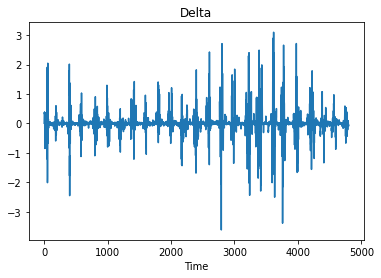

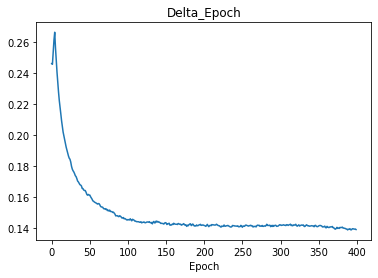

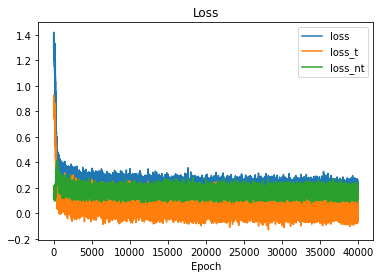

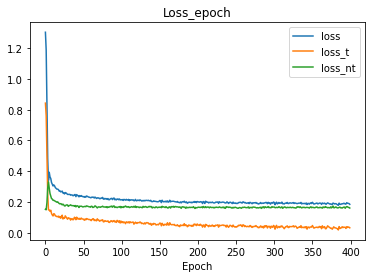

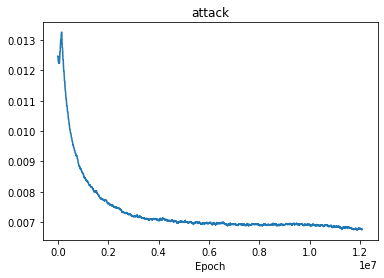

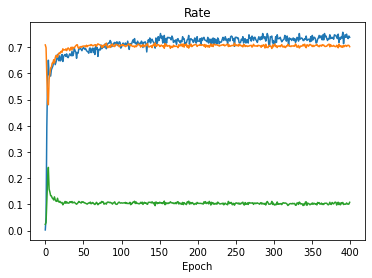

tensor([[ 0.0010,  0.0042,  0.0220,  ..., -0.0120, -0.0050, -0.0099]],
       grad_fn=<SqueezeBackward1>)


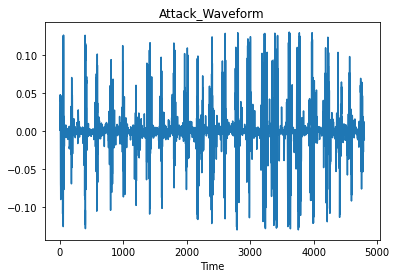

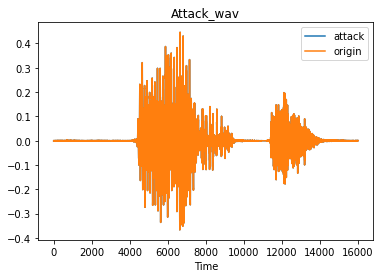


Test Epoch: 0	Attack_Accuracy: 304/412 (74%)


Test Epoch: 0	maintain_Accuracy: 7438/10593 (70%)



In [24]:

time_ = time.strftime('$m_%d_%H_%M_',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.2 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


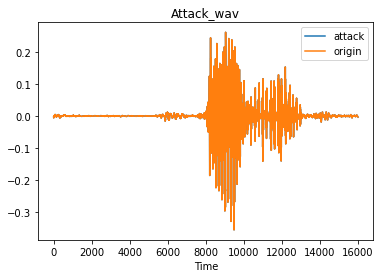


Test Epoch: 0	Attack_Accuracy: 304/412 (74%)


Test Epoch: 0	maintain_Accuracy: 7438/10593 (70%)


Test Epoch: 0	Attack_Accuracy: 1/412 (0%)


Test Epoch: 0	maintain_Accuracy: 10208/10593 (96%)



0.5

In [25]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [26]:
print(len(attack_train_loader))

15


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


